# 5 Regression of California Housing Dataset

### David Nicolay 26296918

In [1]:
# imports
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score

# model result saving
import pickle
import os
from datetime import datetime
import time


# import my utils
import sys
sys.path.append('../')
from src import data_utils, models

# Import the evaluation utilities
from src.active_learning import ModelEvaluator, compare_learning_strategies, ActiveLearningEvaluator
from src.metrics import compute_computational_savings, find_convergence_epoch
from src.active_learning_reg import ActiveLearningRegressionEvaluator

## Data pre-processing

In [2]:
df = pd.read_csv("../datasets/housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
# check for missing values
df.isnull().sum().sort_values(ascending=False)

total_bedrooms        207
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

#### 1. Impute median for total_bedrooms missing values


In [5]:
# impute median for total_bedrooms missing values
df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace=True)
df.isnull().sum().sort_values(ascending=False)

/tmp/ipykernel_60112/1800315542.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace=True)


longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [6]:
df.shape

(20640, 10)

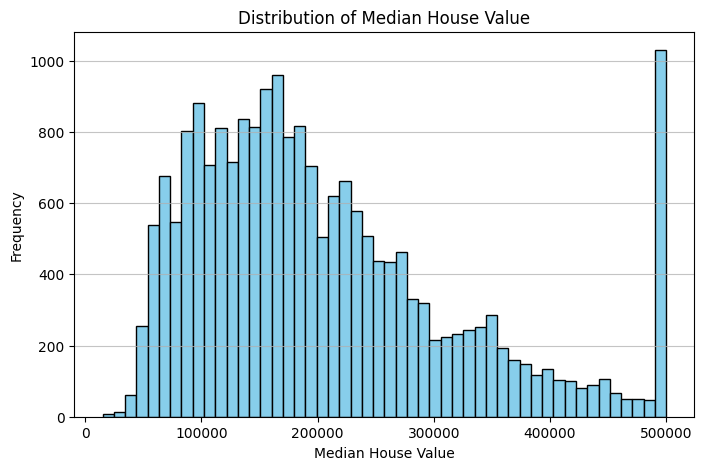

In [8]:
# check distribution of target variable
plt.figure(figsize=(8, 5))
plt.hist(df['median_house_value'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Median House Value')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [9]:
# check levels of the categorical variable
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

#### 2. One-hot encode ocean_proximity categorical variable

In [10]:
# one hot encode ocean_proximity categorical variable
df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,False,False,True,False


### 3. Scale features to [-1, 1]

In [7]:
print(dir(data_utils))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'generate_synthetic_data', 'np', 'pd', 'scale_min_max', 'scale_z_score']


In [12]:
# scale all numeric columns to [-1, 1], but keep boolean columns as-is
# Identify numeric columns (exclude boolean columns from one-hot encoding)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
boolean_cols = [col for col in df.columns if col.startswith('ocean_proximity_')]

# Separate boolean columns
boolean_data = df[boolean_cols].copy()

# Scale only numeric non-boolean columns
cols_to_scale = [col for col in numeric_cols if col not in boolean_cols]
df_to_scale = df[cols_to_scale].copy()

# Apply scaling
df_scaled = data_utils.scale_min_max(df_to_scale, min_val=-1, max_val=1)

# Combine scaled numeric columns with boolean columns
df = pd.concat([df_scaled, boolean_data], axis=1)

df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-0.577689,0.134963,0.568627,-0.955339,-0.960273,-0.982118,-0.958888,0.079337,0.804533,False,False,True,False
1,-0.575697,0.130712,-0.215686,-0.638995,-0.657045,-0.865579,-0.626048,0.076054,0.416493,False,False,True,False
2,-0.579681,0.128587,1.000000,-0.925479,-0.941341,-0.972365,-0.942115,-0.067944,0.390101,False,False,True,False
3,-0.581673,0.128587,1.000000,-0.935297,-0.927374,-0.968889,-0.928301,-0.290603,0.345566,False,False,True,False
4,-0.581673,0.128587,1.000000,-0.917341,-0.913408,-0.968497,-0.915146,-0.538448,0.349277,False,False,True,False


### 4. Prepare X and Y matrices and tensors


In [13]:
# Define target and feature columns
target_col = 'median_house_value'
feature_cols = [col for col in df.columns if col != target_col]

print(f"Target: {target_col}")
print(f"Features ({len(feature_cols)}): {feature_cols}")


Target: median_house_value
Features (12): ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']


In [15]:
# Prepare data
X = df[feature_cols].values
y = df[target_col].values.reshape(-1, 1)
y_raw = y.copy()

# Ensure X is numeric (convert to float64 to avoid object dtype issues)
X = X.astype(np.float64)
y = y.astype(np.float64)

# Convert to torch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

In [11]:
# set matplotlib to Times New Roman font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14


In [18]:
# count features
n_features = X.shape[1]
n_features

12

## Modelling

### Passive learning with stochastic gradient descent

#### Find best control parameters

In [20]:
# Split data - Remove stratify for regression
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=12)

# Hyperparameter search function
def train_and_evaluate(hidden_size, learning_rate, weight_decay, momentum, epochs=200):
    # Use the new RegressionNet model - no output activation
    model = models.RegressionNet(input_size=12, hidden_size=hidden_size, output_size=1)
    
    # Use MSE loss for regression
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
    
    # Training
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Check for NaN loss - early stopping if training becomes unstable
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Warning: Training became unstable (loss={loss.item():.4f}) at epoch {epoch}")
            print(f"Parameters: hidden={hidden_size}, lr={learning_rate}, wd={weight_decay}, momentum={momentum}")
            # Return very poor performance metrics to indicate failed training
            return model, float('inf'), float('inf'), -float('inf'), -float('inf'), losses
        
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        losses.append(loss.item())
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        train_outputs = model(X_train)
        test_outputs = model(X_test)
        
        # Check for NaN outputs
        if torch.isnan(train_outputs).any() or torch.isnan(test_outputs).any():
            print(f"Warning: Model outputs contain NaN values")
            print(f"Parameters: hidden={hidden_size}, lr={learning_rate}, wd={weight_decay}, momentum={momentum}")
            # Return very poor performance metrics to indicate failed training
            return model, float('inf'), float('inf'), -float('inf'), -float('inf'), losses
        
        # Convert to numpy for sklearn metrics
        train_pred = train_outputs.numpy()
        test_pred = test_outputs.numpy()
        y_train_np = y_train.numpy()
        y_test_np = y_test.numpy()
        
        # Additional check for NaN in numpy arrays
        if np.isnan(train_pred).any() or np.isnan(test_pred).any():
            print(f"Warning: Predictions contain NaN values after conversion to numpy")
            print(f"Parameters: hidden={hidden_size}, lr={learning_rate}, wd={weight_decay}, momentum={momentum}")
            # Return very poor performance metrics to indicate failed training
            return model, float('inf'), float('inf'), -float('inf'), -float('inf'), losses
        
        # Calculate MSE and R² for both train and test sets
        train_mse = mean_squared_error(y_train_np, train_pred)
        test_mse = mean_squared_error(y_test_np, test_pred)
        train_r2 = r2_score(y_train_np, train_pred)
        test_r2 = r2_score(y_test_np, test_pred)
    
    return model, train_mse, test_mse, train_r2, test_r2, losses

# Hyperparameter grid search
hidden_sizes = [64, 128, 256, 512]
learning_rates = [0.01, 0.05, 0.1, 0.5]
weight_decays = [0.0, 0.001, 0.01, 0.1]
momentums = [0.0, 0.5, 0.9, 0.95]

best_params = {}
best_test_r2 = -float('inf')  # Use R² as primary metric (higher is better)
results = []

print("Searching for best hyperparameters for regression...")
print("Using RegressionNet model (no output activation)")
print(f"Target range: y ∈ [{y_tensor.min():.3f}, {y_tensor.max():.3f}]")
print()

for hidden_size in hidden_sizes:
    for lr in learning_rates:
        for wd in weight_decays:
            for momentum in momentums:
                model, train_mse, test_mse, train_r2, test_r2, losses = train_and_evaluate(hidden_size, lr, wd, momentum)
                
                # Only add valid results to the results list
                if not (np.isinf(train_mse) or np.isinf(test_mse) or np.isinf(train_r2) or np.isinf(test_r2)):
                    results.append({
                        'hidden_size': hidden_size,
                        'learning_rate': lr,
                        'weight_decay': wd,
                        'momentum': momentum,
                        'train_mse': train_mse,
                        'test_mse': test_mse,
                        'train_r2': train_r2,
                        'test_r2': test_r2
                    })
                    
                    if test_r2 > best_test_r2:
                        best_test_r2 = test_r2
                        best_params = {
                            'hidden_size': hidden_size,
                            'learning_rate': lr,
                            'weight_decay': wd,
                            'momentum': momentum,
                            'train_mse': train_mse,
                            'test_mse': test_mse,
                            'train_r2': train_r2,
                            'test_r2': test_r2
                        }
                    
                    print(f"Hidden: {hidden_size:3d}, LR: {lr:4.2f}, WD: {wd:5.3f}, Mom: {momentum:4.2f} | Train R²: {train_r2:6.4f}, Test R²: {test_r2:6.4f}, Test MSE: {test_mse:8.4f}")
                else:
                    print(f"Hidden: {hidden_size:3d}, LR: {lr:4.2f}, WD: {wd:5.3f}, Mom: {momentum:4.2f} | TRAINING FAILED (unstable)")

print(f"\nBest parameters found:")
for key, value in best_params.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")
print(f"Total valid hyperparameter combinations: {len(results)}")

Searching for best hyperparameters for regression...
Using RegressionNet model (no output activation)
Target range: y ∈ [-1.000, 1.000]

Hidden:  64, LR: 0.01, WD: 0.000, Mom: 0.00 | Train R²: 0.0868, Test R²: 0.0872, Test MSE:   0.2128
Hidden:  64, LR: 0.01, WD: 0.000, Mom: 0.50 | Train R²: 0.1094, Test R²: 0.1068, Test MSE:   0.2083
Hidden:  64, LR: 0.01, WD: 0.000, Mom: 0.90 | Train R²: 0.4650, Test R²: 0.4623, Test MSE:   0.1254
Hidden:  64, LR: 0.01, WD: 0.000, Mom: 0.95 | Train R²: 0.5657, Test R²: 0.5686, Test MSE:   0.1006
Hidden:  64, LR: 0.01, WD: 0.001, Mom: 0.00 | Train R²: 0.1070, Test R²: 0.1056, Test MSE:   0.2086
Hidden:  64, LR: 0.01, WD: 0.001, Mom: 0.50 | Train R²: 0.1689, Test R²: 0.1637, Test MSE:   0.1950
Hidden:  64, LR: 0.01, WD: 0.001, Mom: 0.90 | Train R²: 0.4596, Test R²: 0.4576, Test MSE:   0.1265
Hidden:  64, LR: 0.01, WD: 0.001, Mom: 0.95 | Train R²: 0.5683, Test R²: 0.5723, Test MSE:   0.0997
Hidden:  64, LR: 0.01, WD: 0.010, Mom: 0.00 | Train R²: 0.0866,

In [21]:
# best params
best_params

{'hidden_size': 64,
 'learning_rate': 0.5,
 'weight_decay': 0.0,
 'momentum': 0.95,
 'train_mse': 0.08154012262821198,
 'test_mse': 0.08425397425889969,
 'train_r2': 0.6371121406555176,
 'test_r2': 0.6386530995368958}

In [22]:
# Save best params with pickle
# Create results directory if it doesn't exist
results_dir = "../results/housing"
os.makedirs(results_dir, exist_ok=True)

# Save the best parameters
best_params_filename = os.path.join(results_dir, "best_hyperparameters.pkl")
with open(best_params_filename, 'wb') as f:
    pickle.dump(best_params, f)

# Also save all results from hyperparameter search
hyperparameter_results_filename = os.path.join(results_dir, "hyperparameter_search_results.pkl")
with open(hyperparameter_results_filename, 'wb') as f:
    pickle.dump(results, f)

print(f"Saved best parameters to: {best_params_filename}")
print(f"Saved all hyperparameter search results to: {hyperparameter_results_filename}")
print(f"Best parameters: {best_params}")

Saved best parameters to: ../results/housing/best_hyperparameters.pkl
Saved all hyperparameter search results to: ../results/housing/hyperparameter_search_results.pkl
Best parameters: {'hidden_size': 64, 'learning_rate': 0.5, 'weight_decay': 0.0, 'momentum': 0.95, 'train_mse': 0.08154012262821198, 'test_mse': 0.08425397425889969, 'train_r2': 0.6371121406555176, 'test_r2': 0.6386530995368958}


In [23]:
results_dir = "../results/housing"
best_params_filename = os.path.join(results_dir, "best_hyperparameters.pkl")

# Check if the file exists
if os.path.exists(best_params_filename):
    with open(best_params_filename, 'rb') as f:
        loaded_best_params = pickle.load(f)
    
    print("Successfully loaded best parameters:")
    print(f"Best parameters: {loaded_best_params}")
    
    # Verify they match the current best_params
    if 'best_params' in locals():
        print(f"Parameters match current session: {best_params == loaded_best_params}")
    
    # Use loaded parameters (in case we're running this cell independently)
    best_params = loaded_best_params
    
else:
    print(f"Best parameters file not found at: {best_params_filename}")
    print("Make sure to run the hyperparameter search first!")

Successfully loaded best parameters:
Best parameters: {'hidden_size': 64, 'learning_rate': 0.5, 'weight_decay': 0.0, 'momentum': 0.95, 'train_mse': 0.08154012262821198, 'test_mse': 0.08425397425889969, 'train_r2': 0.6371121406555176, 'test_r2': 0.6386530995368958}
Parameters match current session: True


#### Add input and output sizes to params

In [27]:
# Set correct input and output sizes for regression
best_params['input_size'] = 12  # 12 input features (x)
best_params['output_size'] = 1  # Single output value (y)

## Active Learning with Regression


In [45]:

# Save the original NeuralNet import
from src.models import AdaptiveNet
from sklearn.model_selection import KFold  # For regression CV (no stratification)

# Create a custom ModelEvaluator for regression
class RegressionModelEvaluator(ModelEvaluator):
    def evaluate_passive_learning(self, X, y, best_params, n_trials=50,
                                 use_cv=True, cv_folds=5, epochs=200, 
                                 random_state=12, model_class=None):
        """
        Override to handle regression data (no one-hot encoding).
        
        Args:
            X: Input features tensor
            y: Target values tensor (continuous values, not one-hot)
            best_params: Dictionary with best hyperparameters
            n_trials: Number of trials to run
            use_cv: Whether to use cross-validation
            cv_folds: Number of CV folds
            epochs: Maximum epochs per trial
            random_state: Base random state
            
        Returns:
            Dictionary with comprehensive evaluation results
        """
        print(f"Starting {n_trials} trial evaluation...")
        print(f"Parameters: {best_params}")
        print(f"Cross-validation: {'Yes' if use_cv else 'No'} ({cv_folds} folds)")
        
        self.metrics_tracker.reset()
        
        # For regression, y is already continuous values, no need to convert
        # Use y directly as indices (dummy variable for compatibility)
        y_indices = y
        
        for trial in range(n_trials):
            print(f"Trial {trial + 1}/{n_trials}", end="... ")
            
            start_time = time.time()
            
            if use_cv:
                # Cross-validation approach
                trial_results = self._run_cv_trial(X, y, y_indices, best_params, 
                                                 cv_folds, epochs, random_state + trial, model_class)
            else:
                # Simple train-test split approach
                trial_results = self._run_simple_trial(X, y, y_indices, best_params, 
                                                     epochs, random_state + trial, model_class)
            
            computation_time = time.time() - start_time
            
            # Add results to tracker
            self.metrics_tracker.add_trial_results(
                train_acc=trial_results['train_acc'],
                test_acc=trial_results['test_acc'],
                val_acc=trial_results.get('val_acc'),
                losses=trial_results['losses'],
                val_losses=trial_results.get('val_losses'),
                epochs_converged=trial_results['epochs_converged'],
                num_presentations=trial_results['num_presentations'],
                computation_time=computation_time,
                train_metrics=trial_results.get('train_metrics'),
                test_metrics=trial_results.get('test_metrics'),
                val_metrics=trial_results.get('val_metrics'),
                train_acc_curve=trial_results.get('train_acc_curve'),
                test_acc_curve=trial_results.get('test_acc_curve')
            )
            
            print(f"Test MSE: {-trial_results['test_acc']:.4f}, Time: {computation_time:.2f}s")
        
        # Compute and return comprehensive statistics
        results = self.metrics_tracker.compute_statistics()
        results['learning_type'] = 'passive'
        results['best_params'] = best_params
        
        return results
    
    def _train_model(self, X_train, y_train_idx, X_test, y_test_idx, params, epochs):
        """Override to use AdaptiveNet for regression and track R² scores"""
        
        # Use AdaptiveNet configured for regression
        model = AdaptiveNet(
            input_size=params.get('input_size', 1),
            hidden_size=params['hidden_size'],
            output_size=params.get('output_size', 1),
            use_mse=False,  # We'll use MSE loss externally
            task_type='regression'
        )
        
        # Use MSE loss for regression
        criterion = nn.MSELoss()
        optimizer = optim.SGD(
            model.parameters(),
            lr=params['learning_rate'],
            weight_decay=params['weight_decay'],
            momentum=params.get('momentum', 0.0)
        )
        
        # For regression, targets are already in the right format (continuous values)
        # Convert indices to float if they aren't already
        y_train_target = y_train_idx.float().unsqueeze(1) if y_train_idx.dim() == 1 else y_train_idx.float()
        y_test_target = y_test_idx.float().unsqueeze(1) if y_test_idx.dim() == 1 else y_test_idx.float()
        
        # Training loop
        losses = []
        val_losses = []
        train_acc_curve = []
        test_acc_curve = []
        train_r2_curve = []
        test_r2_curve = []
        
        for epoch in range(epochs):
            # Training step
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train_target)
            loss.backward()
            
            # IMPORTANT: Add gradient clipping 
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            losses.append(loss.item())
            
            # Validation step
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_test)
                val_loss = criterion(val_outputs, y_test_target)
                val_losses.append(val_loss.item())
                
                # For regression, use negative MSE as "accuracy" (higher is better)
                train_outputs = model(X_train)
                train_mse = nn.MSELoss()(train_outputs, y_train_target)
                test_mse = nn.MSELoss()(val_outputs, y_test_target)
                
                train_epoch_acc = -train_mse.item()
                test_epoch_acc = -test_mse.item()
                
                train_acc_curve.append(train_epoch_acc)
                test_acc_curve.append(test_epoch_acc)
                
                # Calculate R² scores
                train_r2 = r2_score(y_train_target.cpu().numpy(), train_outputs.cpu().numpy())
                test_r2 = r2_score(y_test_target.cpu().numpy(), val_outputs.cpu().numpy())
                
                train_r2_curve.append(train_r2)
                test_r2_curve.append(test_r2)
        
        # Find convergence epoch
        epochs_converged = find_convergence_epoch(losses)
        
        # Final evaluation
        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train)
            test_outputs = model(X_test)
            
            train_mse = nn.MSELoss()(train_outputs, y_train_target)
            test_mse = nn.MSELoss()(test_outputs, y_test_target)
            
            train_acc = -train_mse.item()
            test_acc = -test_mse.item()
            
            # Calculate final R² scores
            train_r2 = r2_score(y_train_target.cpu().numpy(), train_outputs.cpu().numpy())
            test_r2 = r2_score(y_test_target.cpu().numpy(), test_outputs.cpu().numpy())
            
            # Create metrics including R² scores
            train_metrics = {
                'accuracy': train_acc, 
                'f1_score': train_acc, 
                'precision': train_acc, 
                'recall': train_acc,
                'r2': train_r2,
                'r2_curve': train_r2_curve
            }
            test_metrics = {
                'accuracy': test_acc, 
                'f1_score': test_acc, 
                'precision': test_acc, 
                'recall': test_acc,
                'r2': test_r2,
                'r2_curve': test_r2_curve
            }
        
        return model, losses, train_acc, test_acc, epochs_converged, train_metrics, test_metrics, val_losses, train_acc_curve, test_acc_curve

    def _run_cv_trial(self, X, y, y_indices, params, cv_folds, epochs, random_state, model_class=None):
        """Override CV trial for regression - no stratification needed"""
        
        # First, create a holdout test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state
        )
        
        # Use regular KFold instead of StratifiedKFold for regression
        kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
        
        # Cross-validation metrics tracking
        cv_train_accs = []
        cv_val_accs = []
        cv_train_metrics = []
        cv_val_metrics = []
        all_losses = []
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(X_temp)):
            X_train = X_temp[train_idx]
            X_val = X_temp[val_idx]
            y_train = y_temp[train_idx]
            y_val = y_temp[val_idx]
            
            # Train model (y_train and y_val are already continuous values)
            model, losses, train_acc, val_acc, _, train_metrics, val_metrics, val_losses, _, _ = self._train_model(
                X_train, y_train, X_val, y_val, params, epochs
            )
            
            cv_train_accs.append(train_acc)
            cv_val_accs.append(val_acc)
            cv_train_metrics.append(train_metrics)
            cv_val_metrics.append(val_metrics)
            all_losses.extend(losses)
        
        # Average CV results
        avg_train_acc = np.mean(cv_train_accs)
        avg_val_acc = np.mean(cv_val_accs)
        
        # Average CV metrics
        avg_train_metrics = self._average_metrics(cv_train_metrics)
        avg_val_metrics = self._average_metrics(cv_val_metrics)
        
        # Final test on holdout set using best parameters
        # Train on all temp data for final test
        final_model, final_losses, _, _, epochs_converged, _, test_metrics, final_val_losses, train_acc_curve, test_acc_curve = self._train_model(
            X_temp, y_temp, X_test, y_test, params, epochs
        )
        
        # Evaluate on test set
        final_model.eval()
        with torch.no_grad():
            test_outputs = final_model(X_test)
            test_target = y_test.float().unsqueeze(1) if y_test.dim() == 1 else y_test.float()
            test_mse = nn.MSELoss()(test_outputs, test_target)
            test_acc = -test_mse.item()  # Use negative MSE as "accuracy"
        
        # Calculate pattern presentations
        num_presentations = len(X_temp) * epochs_converged
        
        return {
            'train_acc': avg_train_acc,
            'val_acc': avg_val_acc,
            'test_acc': test_acc,
            'losses': all_losses,
            'val_losses': final_val_losses,
            'train_metrics': avg_train_metrics,
            'val_metrics': avg_val_metrics,
            'test_metrics': test_metrics,
            'epochs_converged': epochs_converged,
            'num_presentations': num_presentations,
            'train_acc_curve': train_acc_curve,
            'test_acc_curve': test_acc_curve
        }
    
    def _run_simple_trial(self, X, y, y_indices, params, epochs, random_state, model_class=None):
        """Override simple trial for regression"""
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state
        )
        
        # Train model (y_train and y_test are already continuous values)
        model, losses, train_acc, test_acc, epochs_converged, train_metrics, test_metrics, val_losses, train_acc_curve, test_acc_curve = self._train_model(
            X_train, y_train, X_test, y_test, params, epochs
        )
        
        # Calculate pattern presentations
        num_presentations = len(X_train) * epochs_converged
        
        return {
            'train_acc': train_acc,
            'test_acc': test_acc,
            'losses': losses,
            'val_losses': val_losses,
            'train_metrics': train_metrics,
            'test_metrics': test_metrics,
            'epochs_converged': epochs_converged,
            'num_presentations': num_presentations,
            'train_acc_curve': train_acc_curve,
            'test_acc_curve': test_acc_curve
        }
    
    def _average_metrics(self, metrics_list):
        """Average metrics across CV folds, handling R² curves"""
        if not metrics_list:
            return {}
        
        avg_metrics = {}
        # Get all keys from first metrics dict
        keys = metrics_list[0].keys()
        
        for key in keys:
            if key == 'r2_curve':
                # For R² curves, store all curves (don't average)
                avg_metrics[key] = [m[key] for m in metrics_list]
            else:
                # For scalar values, compute mean
                values = [m[key] for m in metrics_list if key in m]
                if values:
                    avg_metrics[key] = np.mean(values)
        
        return avg_metrics



#### Run 50 trials with best control parameters

In [46]:
# Initialize evaluator
evaluator = RegressionModelEvaluator()

# Fix y_tensor format - squeeze to remove extra dimensions
y_for_eval = y_tensor.squeeze()

# Run 50 trials with cross-validation
# IMPORTANT: Use same epochs as grid search (1000) for fair comparison
print("Running 50 trials with best parameters and 5-fold cross-validation...")
print(f"Data shapes: X={X_tensor.shape}, y={y_for_eval.shape}")
passive_results = evaluator.evaluate_passive_learning(
    X=X_tensor,
    y=y_for_eval,  # Use properly formatted y
    best_params=best_params,
    n_trials=50,
    use_cv=False,
    cv_folds=5,
    epochs=200, 
    random_state=12,
)

# Print comprehensive report
print("\n")
evaluator.print_report()

Running 50 trials with best parameters and 5-fold cross-validation...
Data shapes: X=torch.Size([20640, 12]), y=torch.Size([20640])
Starting 50 trial evaluation...
Parameters: {'hidden_size': 64, 'learning_rate': 0.5, 'weight_decay': 0.0, 'momentum': 0.95, 'train_mse': 0.08154012262821198, 'test_mse': 0.08425397425889969, 'train_r2': 0.6371121406555176, 'test_r2': 0.6386530995368958, 'input_size': 12, 'output_size': 1}
Cross-validation: No (5 folds)
Trial 1/50... Test MSE: 0.0813, Time: 0.73s
Trial 2/50... Test MSE: 0.0810, Time: 0.58s
Trial 3/50... Test MSE: 0.0777, Time: 0.58s
Trial 4/50... Test MSE: 0.0836, Time: 0.66s
Trial 5/50... Test MSE: 0.0785, Time: 0.60s
Trial 6/50... Test MSE: 0.0796, Time: 0.58s
Trial 7/50... Test MSE: 0.0813, Time: 0.57s
Trial 8/50... Test MSE: 0.0794, Time: 0.57s
Trial 9/50... Test MSE: 0.0819, Time: 0.60s
Trial 10/50... Test MSE: 0.0846, Time: 0.64s
Trial 11/50... Test MSE: 0.0791, Time: 0.66s
Trial 12/50... Test MSE: 0.0785, Time: 0.73s
Trial 13/50... 

In [47]:
# Save evaluator and passive_results to ../results/housing/


# Create results directory if it doesn't exist
results_dir = "../results/housing"
os.makedirs(results_dir, exist_ok=True)

# Save the evaluator object with all its metrics
evaluator_filename = os.path.join(results_dir, "passive_learning_evaluator.pkl")
with open(evaluator_filename, 'wb') as f:
    pickle.dump(evaluator, f)

# Save the passive_results dictionary
results_filename = os.path.join(results_dir, "passive_learning_results.pkl")
with open(results_filename, 'wb') as f:
    pickle.dump(passive_results, f)

# Also save as JSON for easier inspection (excluding non-serializable objects)
import json

# Create a JSON-serializable version of passive_results
json_results = {}
for key, value in passive_results.items():
    if isinstance(value, (int, float, str, bool, list, dict)):
        json_results[key] = value
    elif hasattr(value, 'tolist'):  # numpy arrays
        json_results[key] = value.tolist() if hasattr(value, 'tolist') else str(value)
    else:
        json_results[key] = str(value)

# Add metadata
json_results['saved_at'] = datetime.now().isoformat()
json_results['dataset'] = 'housing'
json_results['method'] = 'passive_learning_sgd'

json_filename = os.path.join(results_dir, "passive_learning_results.json")
with open(json_filename, 'w') as f:
    json.dump(json_results, f, indent=2)

print(f"Saved evaluator to: {evaluator_filename}")
print(f"Saved passive_results to: {results_filename}")
print(f"Saved JSON results to: {json_filename}")

# Save detailed metrics from the evaluator's tracker
metrics_data = {
    'train_accuracies': evaluator.metrics_tracker.train_accuracies,
    'test_accuracies': evaluator.metrics_tracker.test_accuracies,
    'val_accuracies': evaluator.metrics_tracker.val_accuracies,
    'losses_per_trial': evaluator.metrics_tracker.losses_per_trial,
    'epochs_to_converge': evaluator.metrics_tracker.epochs_to_converge,
    'pattern_presentations': evaluator.metrics_tracker.pattern_presentations,
    'computation_times': evaluator.metrics_tracker.computation_times,
    'saved_at': datetime.now().isoformat(),
    'n_trials': 50,
    'method': 'passive_learning_sgd'
}

metrics_filename = os.path.join(results_dir, "passive_learning_detailed_metrics.pkl")
with open(metrics_filename, 'wb') as f:
    pickle.dump(metrics_data, f)

print(f"Saved detailed metrics to: {metrics_filename}")

# Create a summary text file for easy reference
summary_filename = os.path.join(results_dir, "passive_learning_summary.txt")
with open(summary_filename, 'w') as f:
    f.write("PASSIVE LEARNING RESULTS SUMMARY\n")
    f.write("=" * 50 + "\n")
    f.write(f"Saved at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Dataset: housing\n")
    f.write(f"Method: Passive Learning with SGD\n")
    f.write(f"Number of trials: 50\n")
    f.write(f"Cross-validation: 5-fold\n\n")
    
    f.write("PERFORMANCE METRICS:\n")
    f.write("-" * 20 + "\n")
    f.write(f"Training Accuracy: {passive_results['train_acc_mean']:.4f} ± {passive_results['train_acc_std']:.4f}\n")
    f.write(f"Test Accuracy: {passive_results['test_acc_mean']:.4f} ± {passive_results['test_acc_std']:.4f}\n")
    f.write(f"Best Test Accuracy: {passive_results['best_test_acc']:.4f}\n")
    f.write(f"Convergence Rate: {passive_results['convergence_rate']:.1%}\n")
    f.write(f"Avg Pattern Presentations: {passive_results['avg_pattern_presentations']:.1f}\n")
    
    f.write(f"\nBEST PARAMETERS:\n")
    f.write("-" * 15 + "\n")
    for param, value in best_params.items():
        f.write(f"{param}: {value}\n")

print(f"Saved summary to: {summary_filename}")
print(f"\nAll files saved in: {results_dir}")

Saved evaluator to: ../results/housing/passive_learning_evaluator.pkl
Saved passive_results to: ../results/housing/passive_learning_results.pkl
Saved JSON results to: ../results/housing/passive_learning_results.json
Saved detailed metrics to: ../results/housing/passive_learning_detailed_metrics.pkl
Saved summary to: ../results/housing/passive_learning_summary.txt

All files saved in: ../results/housing


In [48]:
# UNCOMMENT TO LOAD THE SAVED EVALUATOR AND RESULTS
# import pickle

# # Load the evaluator
# with open('../results/housing/passive_learning_evaluator.pkl', 'rb') as f:
#     loaded_evaluator = pickle.load(f)

# # Load the results
# with open('../results/housing/passive_learning_results.pkl', 'rb') as f:
#     loaded_passive_results = pickle.load(f)

In [49]:

passive_learning_results = passive_results.copy()

# Extract key metrics for detailed analysis
print(f"\nDETAILED METRICS SUMMARY")
print("=" * 60)
print(f"Training Accuracy: {passive_results['train_acc_mean']:.4f} ± {passive_results['train_acc_std']:.4f}")
print(f"Test Accuracy: {passive_results['test_acc_mean']:.4f} ± {passive_results['test_acc_std']:.4f}")
# print(f"Validation Accuracy: {passive_results['val_acc_mean']:.4f} ± {passive_results['val_acc_std']:.4f}")

print(f"\n95% Confidence Intervals:")
print(f"  Train: [{passive_results['train_acc_95ci'][0]:.4f}, {passive_results['train_acc_95ci'][1]:.4f}]")
print(f"  Test:  [{passive_results['test_acc_95ci'][0]:.4f}, {passive_results['test_acc_95ci'][1]:.4f}]")

print(f"\nBest Model Performance:")
print(f"  Best Test Accuracy: {passive_results['best_test_acc']:.4f}")
print(f"  Pattern Presentations: {passive_results['best_test_patterns']}")
print(f"  Generalization Factor: {passive_results['generalization_factor']:.4f}")

print(f"\nEfficiency Metrics:")
print(f"  Avg Pattern Presentations: {passive_results['avg_pattern_presentations']:.1f} ± {passive_results['std_pattern_presentations']:.1f}")
print(f"  Convergence Rate: {passive_results['convergence_rate']:.1%}")
if passive_results['avg_epochs_to_converge'] is not None:
    print(f"  Avg Epochs to Converge: {passive_results['avg_epochs_to_converge']:.1f} ± {passive_results['std_epochs_to_converge']:.1f}")


DETAILED METRICS SUMMARY
Training Accuracy: -0.0835 ± 0.0202
Test Accuracy: -0.0842 ± 0.0217

95% Confidence Intervals:
  Train: [-0.0893, -0.0777]
  Test:  [-0.0904, -0.0780]

Best Model Performance:
  Best Test Accuracy: -0.0755
  Pattern Presentations: 1188864
  Generalization Factor: 0.0000

Efficiency Metrics:
  Avg Pattern Presentations: 1246656.0 ± 278916.0
  Convergence Rate: 0.0%


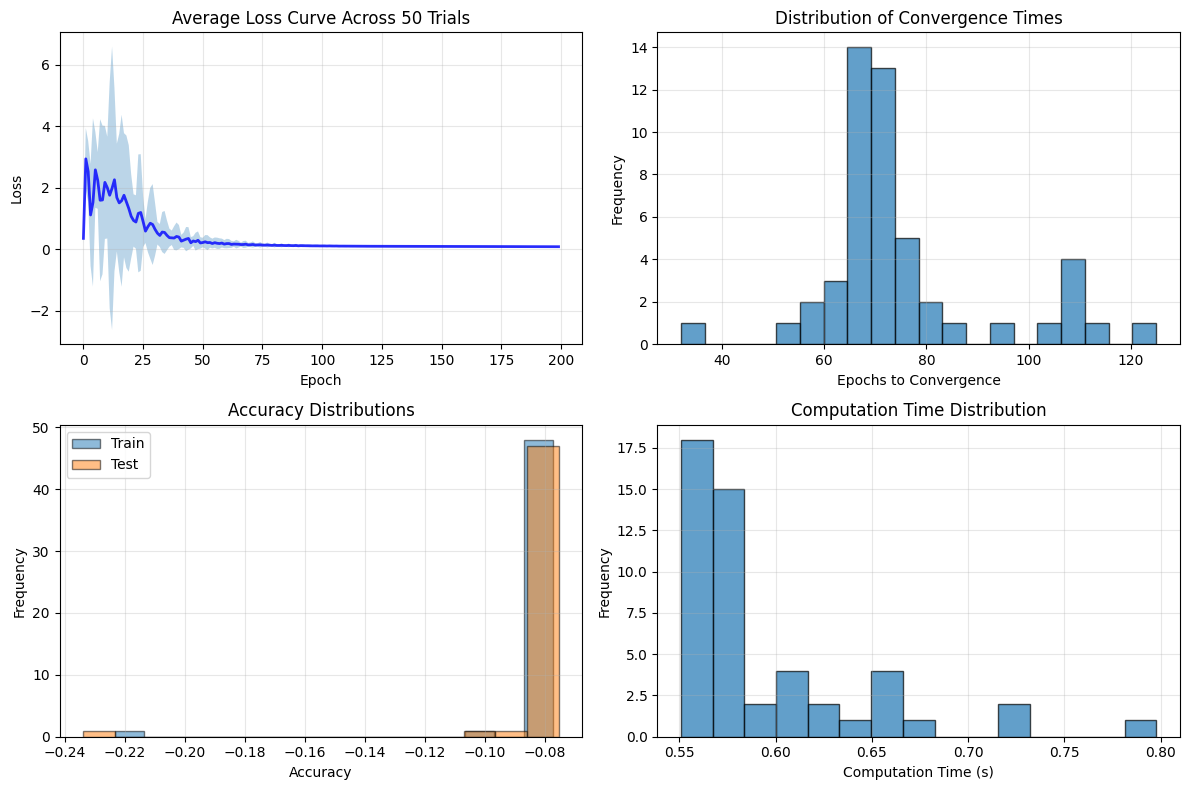


COMPUTATIONAL EFFICIENCY
Average computation time per trial: 0.596 ± 0.051 seconds
Total evaluation time: 29.8 seconds (0.5 minutes)


In [50]:
# Analyze loss convergence patterns across trials


# Plot average loss curves
plt.figure(figsize=(12, 8))

# Get all losses from trials
all_losses = evaluator.metrics_tracker.losses_per_trial

# Calculate average loss curve (pad shorter sequences with last value)
max_epochs = max(len(losses) for losses in all_losses)
padded_losses = []
for losses in all_losses:
    padded = losses + [losses[-1]] * (max_epochs - len(losses))
    padded_losses.append(padded)

avg_losses = np.mean(padded_losses, axis=0)
std_losses = np.std(padded_losses, axis=0)

plt.subplot(2, 2, 1)
epochs = range(len(avg_losses))
plt.plot(epochs, avg_losses, 'b-', alpha=0.8, linewidth=2)
plt.fill_between(epochs, avg_losses - std_losses, avg_losses + std_losses, alpha=0.3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss Curve Across 50 Trials')
plt.grid(True, alpha=0.3)

# Plot convergence distribution
plt.subplot(2, 2, 2)
convergence_epochs = evaluator.metrics_tracker.epochs_to_converge
plt.hist(convergence_epochs, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Epochs to Convergence')
plt.ylabel('Frequency')
plt.title('Distribution of Convergence Times')
plt.grid(True, alpha=0.3)

# Plot accuracy distributions
plt.subplot(2, 2, 3)
train_accs = evaluator.metrics_tracker.train_accuracies
test_accs = evaluator.metrics_tracker.test_accuracies
plt.hist(train_accs, alpha=0.5, label='Train', bins=15, edgecolor='black')
plt.hist(test_accs, alpha=0.5, label='Test', bins=15, edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Accuracy Distributions')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot computation time distribution
plt.subplot(2, 2, 4)
comp_times = evaluator.metrics_tracker.computation_times
plt.hist(comp_times, bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('Computation Time (s)')
plt.ylabel('Frequency')
plt.title('Computation Time Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCOMPUTATIONAL EFFICIENCY")
print(f"Average computation time per trial: {np.mean(comp_times):.3f} ± {np.std(comp_times):.3f} seconds")
print(f"Total evaluation time: {np.sum(comp_times):.1f} seconds ({np.sum(comp_times)/60:.1f} minutes)")

In [51]:
# Create a comprehensive results dictionary for later use
passive_learning_summary = {
    'strategy': 'Passive Learning (SGD)',
    'parameters': best_params,
    'results': passive_results,
    'raw_data': {
        'train_accuracies': evaluator.metrics_tracker.train_accuracies,
        'test_accuracies': evaluator.metrics_tracker.test_accuracies,
        'val_accuracies': evaluator.metrics_tracker.val_accuracies,
        'losses_per_trial': evaluator.metrics_tracker.losses_per_trial,
        'epochs_to_converge': evaluator.metrics_tracker.epochs_to_converge,
        'pattern_presentations': evaluator.metrics_tracker.pattern_presentations,
        'computation_times': evaluator.metrics_tracker.computation_times
    }
}

# Save key results for comparison
print("Passive learning evaluation completed!")
print(f"Results saved for comparison with active learning methods")
print(f"Best test accuracy achieved: {passive_results['best_test_acc']:.4f}")
print(f"Average test accuracy: {passive_results['test_acc_mean']:.4f} ± {passive_results['test_acc_std']:.4f}")
print(f"Average training efficiency: {passive_results['avg_pattern_presentations']:.0f} pattern presentations")

Passive learning evaluation completed!
Results saved for comparison with active learning methods
Best test accuracy achieved: -0.0755
Average test accuracy: -0.0842 ± 0.0217
Average training efficiency: 1246656 pattern presentations


#### Evaluation

In [52]:
# 1. Print metrics
passive_learning_results

{'train_acc_mean': np.float64(-0.08347626119852065),
 'train_acc_std': np.float64(0.0201879549432944),
 'test_acc_mean': np.float64(-0.08419867873191833),
 'test_acc_std': np.float64(0.021678094400978228),
 'num_trials': 50,
 'train_f1_mean': np.float64(0.0),
 'train_f1_std': np.float64(0.0),
 'train_precision_mean': np.float64(-0.08347626119852065),
 'train_precision_std': np.float64(0.0201879549432944),
 'train_recall_mean': np.float64(-0.08347626119852065),
 'train_recall_std': np.float64(0.0201879549432944),
 'train_mcc_mean': np.float64(0.0),
 'train_mcc_std': np.float64(0.0),
 'test_f1_mean': np.float64(0.0),
 'test_f1_std': np.float64(0.0),
 'test_precision_mean': np.float64(-0.08419867873191833),
 'test_precision_std': np.float64(0.021678094400978228),
 'test_recall_mean': np.float64(-0.08419867873191833),
 'test_recall_std': np.float64(0.021678094400978228),
 'test_mcc_mean': np.float64(0.0),
 'test_mcc_std': np.float64(0.0),
 'train_r2_mean': np.float64(0.6309724080562592),
 

In [53]:
# 2. Print epochs to converge
evaluator.metrics_tracker.epochs_to_converge

[63,
 69,
 69,
 73,
 70,
 78,
 75,
 69,
 72,
 65,
 109,
 67,
 70,
 69,
 70,
 105,
 77,
 68,
 74,
 69,
 72,
 32,
 75,
 114,
 87,
 72,
 70,
 125,
 110,
 81,
 95,
 64,
 69,
 59,
 82,
 109,
 54,
 66,
 58,
 107,
 72,
 63,
 69,
 67,
 72,
 66,
 72,
 71,
 69,
 72]

Loss curves saved to ../results/housing/losses.pdf


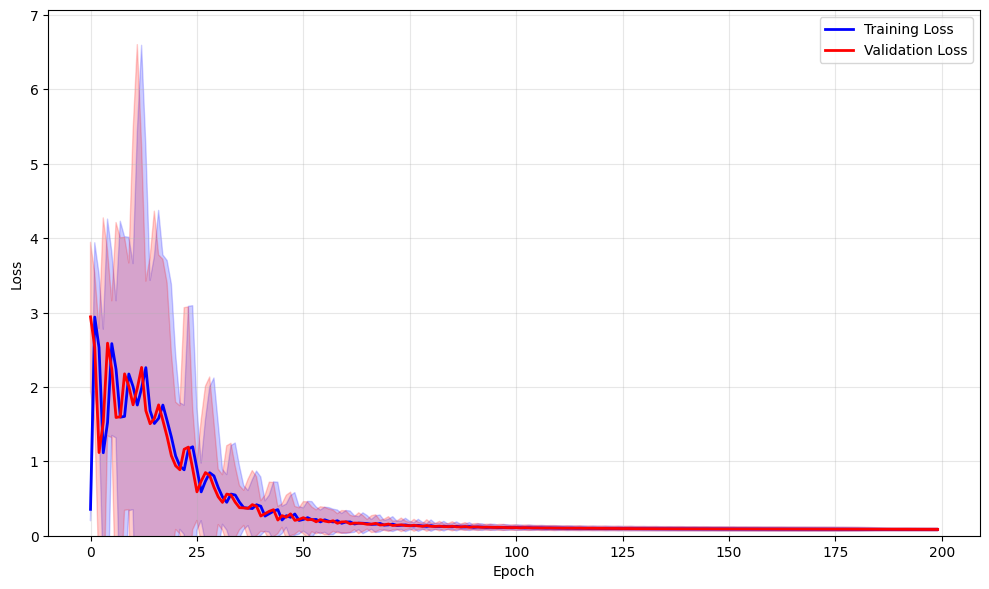

In [54]:
# 3. Plot Training & Validation Accuracies over epochs
evaluator.metrics_tracker.plot_loss_curves(
    title="",
    save_path="../results/housing/losses.pdf"
)


### SASLA Active Learning Implementation



#### Key SASLA Components:

1. **Exact Sensitivity Calculation**: Using derivatives (Equation 4): 
   `S_oz(k,i) = (1 - o_k) * o_k * Σ_j [w_kj * (1 - y_j) * y_j * v_ji]`

2. **Pattern Informativeness**: Mathematical definition (Equations 1-2) with sum-norm followed by max-norm

3. **Selection Strategy**: Select patterns with informativeness > `(1-α) * average_informativeness`

4. **Selection Constant α = 0.9**: Conservative approach to retain high-quality patterns

5. **Selection Frequency**: Every epoch (configurable interval)

In [55]:
# Output Sensitivity Active Learning Evaluation (CORRECTED SASLA) - REGRESSION VERSION


print("=== CORRECTED SASLA ACTIVE LEARNING EVALUATION (REGRESSION) ===")
print("Implementing true SASLA (Sensitivity Analysis for Selective Learning Algorithm)")
print("Adapted for regression tasks:")
print("- Exact derivative-based sensitivity calculation")
print("- Pattern informativeness for continuous outputs")
print("- Selection threshold: (1-α) * average_informativeness")
print("- α = 0.9 (conservative selection constant)")
print("- Using R² score as the primary evaluation metric")
print()

# Create evaluator for output sensitivity (regression)
os_evaluator = ActiveLearningRegressionEvaluator(convergence_threshold=0.95)

# Run evaluation with correct SASLA parameters
print("Running Output Sensitivity (SASLA) evaluation for regression...")
print("This may take some time due to derivative calculations...")
os_results = os_evaluator.evaluate_active_learning(
    X_tensor, y_tensor,
    best_params,
    strategy='output_sensitivity',
    n_trials=50,
    use_cv=False,
    cv_folds=5,
    epochs=200,
    random_state=12,
    # SASLA-specific parameters (from the paper)
    alpha=0.9,                      # Selection constant (conservative approach)
    selection_interval=1            # Apply selection every epoch
)

print("Output Sensitivity (SASLA) evaluation completed!")
print()

# Print detailed report
os_evaluator.print_report()

# Store results for comparison
output_sensitivity_results = os_results.copy()

print(f"\nTraining Set Reduction Summary:")
print("="*50)
for epoch, stats in output_sensitivity_results.get('training_set_reductions', {}).items():
    print(f"At {epoch}: {stats['mean']:.2f}% ± {stats['std']:.2f}% reduction")

=== CORRECTED SASLA ACTIVE LEARNING EVALUATION (REGRESSION) ===
Implementing true SASLA (Sensitivity Analysis for Selective Learning Algorithm)
Adapted for regression tasks:
- Exact derivative-based sensitivity calculation
- Pattern informativeness for continuous outputs
- Selection threshold: (1-α) * average_informativeness
- α = 0.9 (conservative selection constant)
- Using R² score as the primary evaluation metric

Running Output Sensitivity (SASLA) evaluation for regression...
This may take some time due to derivative calculations...
Starting 50 trial evaluation for output_sensitivity active learning (regression)...
Parameters: {'hidden_size': 64, 'learning_rate': 0.5, 'weight_decay': 0.0, 'momentum': 0.95, 'train_mse': 0.08154012262821198, 'test_mse': 0.08425397425889969, 'train_r2': 0.6371121406555176, 'test_r2': 0.6386530995368958, 'input_size': 12, 'output_size': 1}
Cross-validation: No (5 folds)
Trial 1/50
Trial 2/50
Trial 3/50
Trial 4/50
Trial 5/50
Trial 6/50
Trial 7/50
Trial

In [56]:
# run single trial of output sensitivity approach - REGRESSION VERSION

# Create evaluator for output sensitivity (regression)
os_evaluator_single = ActiveLearningRegressionEvaluator(convergence_threshold=0.95)

# Run evaluation with correct SASLA parameters

os_results_single = os_evaluator_single.evaluate_active_learning(
    X_tensor, y_tensor,
    best_params,
    strategy='output_sensitivity',
    n_trials=1,
    use_cv=False,
    cv_folds=5,
    epochs=200,
    random_state=12,
    # SASLA-specific parameters (from the paper)
    alpha=0.9,                      # Selection constant (conservative approach)
    selection_interval=1            # Apply selection every epoch
)

Starting 1 trial evaluation for output_sensitivity active learning (regression)...
Parameters: {'hidden_size': 64, 'learning_rate': 0.5, 'weight_decay': 0.0, 'momentum': 0.95, 'train_mse': 0.08154012262821198, 'test_mse': 0.08425397425889969, 'train_r2': 0.6371121406555176, 'test_r2': 0.6386530995368958, 'input_size': 12, 'output_size': 1}
Cross-validation: No (5 folds)
Trial 1/1


/home/davidnicolay/Documents/ml441/ml441_assignments/assign3/notebooks/../src/metrics.py:191: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  scale=stats.sem(train_r2_array))
/home/davidnicolay/Documents/ml441/ml441_assignments/assign3/notebooks/../src/metrics.py:201: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  scale=stats.sem(test_r2_array))
/home/davidnicolay/Documents/ml441/ml441_assignments/assign3/notebooks/../src/metrics.py:238: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  scale=stats.sem(train_acc_array))
/home/davidnicolay/Documents/ml441/ml441_assignments/assign3/notebooks/../src/metrics.py:241: SmallSampleWarning: One or more sample arguments is too small; all returned values will

#### Evaluation

In [57]:
# 1. Print metrics
output_sensitivity_results

{'train_acc_mean': np.float64(-0.09212486207485199),
 'train_acc_std': np.float64(0.008037778080730877),
 'test_acc_mean': np.float64(-0.09260547205805779),
 'test_acc_std': np.float64(0.00880430159705304),
 'num_trials': 50,
 'train_f1_mean': np.float64(0.0),
 'train_f1_std': np.float64(0.0),
 'train_precision_mean': np.float64(0.0),
 'train_precision_std': np.float64(0.0),
 'train_recall_mean': np.float64(0.0),
 'train_recall_std': np.float64(0.0),
 'train_mcc_mean': np.float64(0.0),
 'train_mcc_std': np.float64(0.0),
 'test_f1_mean': np.float64(0.0),
 'test_f1_std': np.float64(0.0),
 'test_precision_mean': np.float64(0.0),
 'test_precision_std': np.float64(0.0),
 'test_recall_mean': np.float64(0.0),
 'test_recall_std': np.float64(0.0),
 'test_mcc_mean': np.float64(0.0),
 'test_mcc_std': np.float64(0.0),
 'train_r2_mean': np.float64(0.5803850448131561),
 'train_r2_std': np.float64(0.0679724167435089),
 'train_r2_95ci': (np.float64(0.560871375456644),
  np.float64(0.5998987141696682))

In [58]:
# 2. Print epochs to converge
os_evaluator.metrics_tracker.epochs_to_converge

[72,
 77,
 49,
 69,
 68,
 81,
 69,
 66,
 65,
 73,
 67,
 66,
 67,
 70,
 67,
 67,
 67,
 67,
 68,
 88,
 69,
 118,
 58,
 100,
 64,
 50,
 65,
 70,
 65,
 67,
 70,
 68,
 68,
 73,
 72,
 88,
 68,
 75,
 66,
 69,
 69,
 83,
 71,
 94,
 71,
 69,
 69,
 37,
 67,
 70]

In [59]:
# add size 120 for epoch 0 to list at start
os_evaluator_single.training_set_sizes_by_epoch = {0: [120], **os_evaluator_single.training_set_sizes_by_epoch}

In [61]:
# 3. Plot training set size reduction over epochs using results from single trial


# # plot it
# plt.figure(figsize=(8, 6))
# epochs = list(os_evaluator_single.training_set_sizes_by_epoch.keys())
# sizes = list(os_evaluator_single.training_set_sizes_by_epoch.values())
# plt.plot(epochs, sizes, marker='o', color = 'orange')
# plt.xlabel('Epoch')
# plt.ylabel('Labeled Training Set Size')
# plt.grid(True, alpha=0.3)
# plt.savefig('../results/housing/os_training_set_size_reduction.pdf', dpi=300, bbox_inches='tight')
# plt.show()


Loss curves saved to ../results/housing/os_losses.pdf


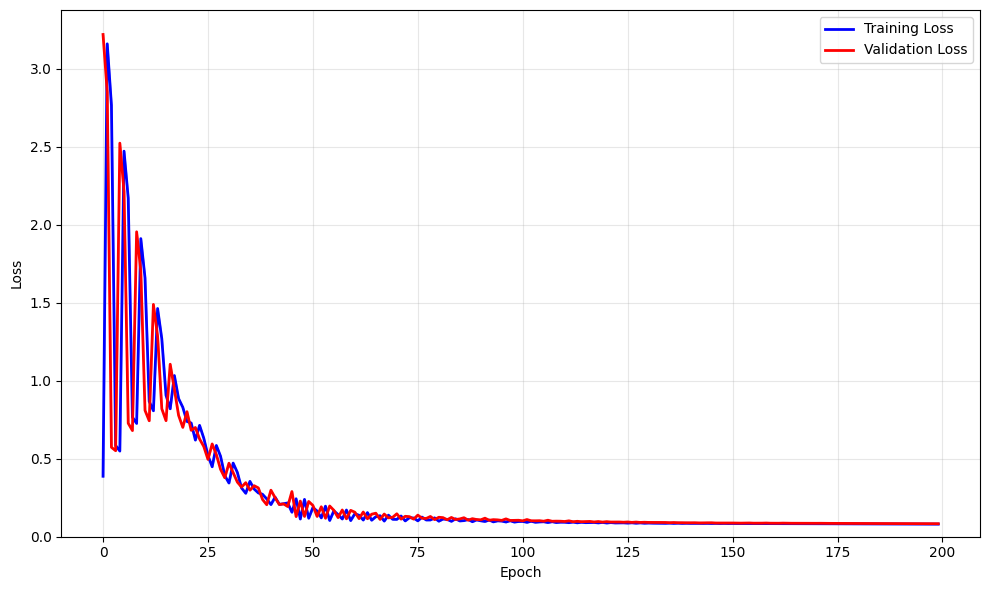

In [62]:
# 4. Plot Training & Validation Accuracies over epochs
os_evaluator_single.metrics_tracker.plot_loss_curves(
    title="",
    save_path="../results/housing/os_losses.pdf"
)

### Active learning with uncertainty sampling



In [63]:
# Uncertainty sampling with enhanced training set size tracking
print("=" * 80)
print("RUNNING UNCERTAINTY SAMPLING WITH ENHANCED TRACKING")
print("=" * 80)
print()

# Create new evaluator for enhanced uncertainty sampling
us_evaluator_enhanced = ActiveLearningRegressionEvaluator(convergence_threshold=0.95)

print("Running Enhanced Uncertainty Sampling Active Learning evaluation...")
us_results_enhanced = us_evaluator_enhanced.evaluate_active_learning(
    X=X_tensor,
    y=y_tensor,
    best_params=best_params,
    strategy='uncertainty_sampling',
    n_trials=50,
    use_cv=False,
    cv_folds=5,
    epochs=200,
    random_state=12,
    uncertainty_method='entropy'
)

print("\nEvaluation completed!")

RUNNING UNCERTAINTY SAMPLING WITH ENHANCED TRACKING

Running Enhanced Uncertainty Sampling Active Learning evaluation...
Starting 50 trial evaluation for uncertainty_sampling active learning (regression)...
Parameters: {'hidden_size': 64, 'learning_rate': 0.5, 'weight_decay': 0.0, 'momentum': 0.95, 'train_mse': 0.08154012262821198, 'test_mse': 0.08425397425889969, 'train_r2': 0.6371121406555176, 'test_r2': 0.6386530995368958, 'input_size': 12, 'output_size': 1}
Cross-validation: No (5 folds)
Trial 1/50
Trial 2/50
Trial 3/50
Trial 4/50
Trial 5/50
Trial 6/50
Trial 7/50
Trial 8/50
Trial 9/50
Trial 10/50
Trial 11/50
Trial 12/50
Trial 13/50
Trial 14/50
Trial 15/50
Trial 16/50
Trial 17/50
Trial 18/50
Trial 19/50
Trial 20/50
Trial 21/50
Trial 22/50
Trial 23/50
Trial 24/50
Trial 25/50
Trial 26/50
Trial 27/50
Trial 28/50
Trial 29/50
Trial 30/50
Trial 31/50
Trial 32/50
Trial 33/50
Trial 34/50
Trial 35/50
Trial 36/50
Trial 37/50
Trial 38/50
Trial 39/50
Trial 40/50
Trial 41/50
Trial 42/50
Trial 43

In [64]:
# Print detailed results with training set size tracking
print("\n" + "=" * 80)
print("ENHANCED UNCERTAINTY SAMPLING RESULTS")
print("=" * 80)

us_evaluator_enhanced.print_report()

print(f"\nTRAINING SET SIZE ANALYSIS")
print("=" * 50)

# Final training set sizes
if 'final_training_set_size_mean' in us_results_enhanced:
    print(f"Original Training Set Size: {us_results_enhanced['original_training_set_size_mean']:.0f}")
    print(f"Final Training Set Size: {us_results_enhanced['final_training_set_size_mean']:.1f} ± {us_results_enhanced['final_training_set_size_std']:.1f}")
    print(f"Training Set Reduction: {us_results_enhanced['training_set_reduction_mean']:.1f}% ± {us_results_enhanced['training_set_reduction_std']:.1f}%")

# Training set sizes at specific epochs
if 'training_set_sizes_by_epoch' in us_results_enhanced:
    print(f"\nTraining Set Sizes at Specific Epochs:")
    print("-" * 40)
    for epoch_key, stats in us_results_enhanced['training_set_sizes_by_epoch'].items():
        epoch = epoch_key.replace('size_at_', '').replace('_epochs', '')
        print(f"  Epoch {epoch:>4}: {stats['mean']:>6.1f} ± {stats['std']:>5.1f} samples (range: {stats['min']:.0f}-{stats['max']:.0f})")

# Store results for comparison
uncertainty_sampling_results_enhanced = us_results_enhanced.copy()


ENHANCED UNCERTAINTY SAMPLING RESULTS
COMPREHENSIVE EVALUATION REPORT

ACCURACY METRICS (n=50 trials)
--------------------------------------------------
Train Accuracy: -0.1022 ± 0.0194
Test Accuracy:  -0.1027 ± 0.0198

CLASSIFICATION METRICS
--------------------------------------------------
F1 Score:
  Train: 0.0000 ± 0.0000
  Test:  0.0000 ± 0.0000
Precision:
  Train: 0.0000 ± 0.0000
  Test:  0.0000 ± 0.0000
Recall:
  Train: 0.0000 ± 0.0000
  Test:  0.0000 ± 0.0000
Matthews Correlation Coefficient (MCC):
  Train: 0.0000 ± 0.0000
  Test:  0.0000 ± 0.0000

REGRESSION METRICS (R²)
--------------------------------------------------
R² Score:
  Train: 0.7724 ± 0.0619
  Test:  0.5469 ± 0.0906

R² 95% Confidence Intervals:
  Train: [0.7546, 0.7902]
  Test:  [0.5208, 0.5729]

95% CONFIDENCE INTERVALS
--------------------------------------------------
Train Accuracy: [-0.1077, -0.0966]
Test Accuracy:  [-0.1084, -0.0971]

BEST GENERALIZATION
--------------------------------------------------

#### Evaluation

In [65]:
# 1. Print all results
us_results_enhanced

{'train_acc_mean': np.float64(-0.10216798201203346),
 'train_acc_std': np.float64(0.019356252198767663),
 'test_acc_mean': np.float64(-0.10273117661476135),
 'test_acc_std': np.float64(0.019752814755984706),
 'num_trials': 50,
 'train_f1_mean': np.float64(0.0),
 'train_f1_std': np.float64(0.0),
 'train_precision_mean': np.float64(0.0),
 'train_precision_std': np.float64(0.0),
 'train_recall_mean': np.float64(0.0),
 'train_recall_std': np.float64(0.0),
 'train_mcc_mean': np.float64(0.0),
 'train_mcc_std': np.float64(0.0),
 'test_f1_mean': np.float64(0.0),
 'test_f1_std': np.float64(0.0),
 'test_precision_mean': np.float64(0.0),
 'test_precision_std': np.float64(0.0),
 'test_recall_mean': np.float64(0.0),
 'test_recall_std': np.float64(0.0),
 'test_mcc_mean': np.float64(0.0),
 'test_mcc_std': np.float64(0.0),
 'train_r2_mean': np.float64(0.7724046242237091),
 'train_r2_std': np.float64(0.06188564968967571),
 'train_r2_95ci': (np.float64(0.7546383572022767),
  np.float64(0.790170891245141

In [66]:
# 2. Print epochs to converge
us_evaluator_enhanced.metrics_tracker.epochs_to_converge

[80,
 179,
 110,
 90,
 120,
 120,
 130,
 187,
 105,
 128,
 185,
 120,
 120,
 107,
 200,
 130,
 158,
 109,
 183,
 130,
 100,
 200,
 100,
 80,
 148,
 200,
 140,
 110,
 128,
 200,
 120,
 120,
 120,
 90,
 100,
 100,
 114,
 120,
 120,
 100,
 98,
 86,
 100,
 130,
 130,
 100,
 120,
 120,
 200,
 90]

Loss curves saved to ../results/housing/us_losses.pdf


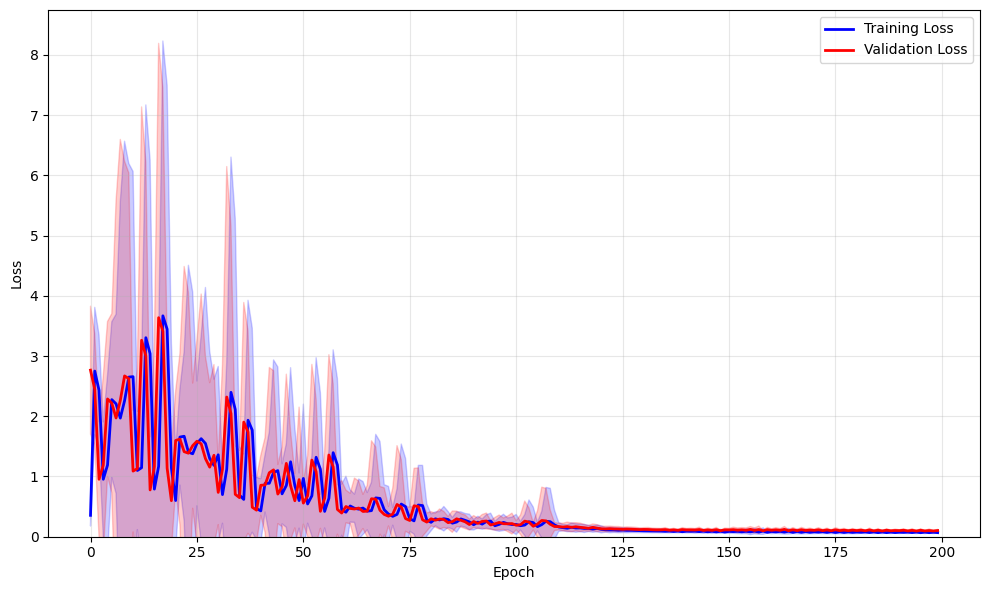

In [67]:
# 3. Plot Training & Validation Accuracies over epochs
us_evaluator_enhanced.metrics_tracker.plot_loss_curves(
    title="",
    save_path="../results/housing/us_losses.pdf"
)


In [68]:
# # 3. TODO Plot F1 vs instance
# us_evaluator_enhanced.plot_f1_vs_instances(us_results_enhanced, 
#     title="",
#     save_path="../results/housing/f1_vs_instances.png"
# )


### Active learning with uncertainty sampling Ensemble

In [69]:
# Ensemble Uncertainty Sampling Active Learning Evaluation
print("=" * 80)
print("RUNNING ENSEMBLE UNCERTAINTY SAMPLING ACTIVE LEARNING")
print("=" * 80)
print()
print("Ensemble approach:")
print("1. Train multiple NNs with different random initializations")
print("2. At inference, average predictions across ensemble members")
print("3. Uncertainty = variance across ensemble predictions")
print("4. Select samples with highest prediction variance for labeling")
print("5. Using 3 models in ensemble for computational efficiency")
print()

# Create evaluator for ensemble uncertainty sampling
ensemble_evaluator = ActiveLearningRegressionEvaluator(convergence_threshold=0.95)

print("Running Ensemble Uncertainty Sampling evaluation...")
print("Using 3 models in ensemble (kept small for efficiency)...")
ensemble_results = ensemble_evaluator.evaluate_active_learning(
    X=X_tensor,
    y=y_tensor,
    best_params=best_params,
    strategy='ensemble_uncertainty',
    n_trials=50,
    use_cv=False,
    cv_folds=5,
    epochs=200,
    random_state=12,
    n_ensemble=3  # Keep ensemble small for computational efficiency
)

print("\nEnsemble Uncertainty Sampling evaluation completed!")

RUNNING ENSEMBLE UNCERTAINTY SAMPLING ACTIVE LEARNING

Ensemble approach:
1. Train multiple NNs with different random initializations
2. At inference, average predictions across ensemble members
3. Uncertainty = variance across ensemble predictions
4. Select samples with highest prediction variance for labeling
5. Using 3 models in ensemble for computational efficiency

Running Ensemble Uncertainty Sampling evaluation...
Using 3 models in ensemble (kept small for efficiency)...
Starting 50 trial evaluation for ensemble_uncertainty active learning (regression)...
Parameters: {'hidden_size': 64, 'learning_rate': 0.5, 'weight_decay': 0.0, 'momentum': 0.95, 'train_mse': 0.08154012262821198, 'test_mse': 0.08425397425889969, 'train_r2': 0.6371121406555176, 'test_r2': 0.6386530995368958, 'input_size': 12, 'output_size': 1}
Cross-validation: No (5 folds)
Trial 1/50
Trial 2/50
Trial 3/50
Trial 4/50
Trial 5/50
Trial 6/50
Trial 7/50
Trial 8/50
Trial 9/50
Trial 10/50
Trial 11/50
Trial 12/50
Trial 

In [70]:
# Print detailed results with training set size tracking
print("\n" + "=" * 80)
print("ENSEMBLE UNCERTAINTY SAMPLING RESULTS")
print("=" * 80)

ensemble_evaluator.print_report()

print(f"\nTRAINING SET SIZE ANALYSIS")
print("=" * 50)

# Final training set sizes
if 'final_training_set_size_mean' in ensemble_results:
    print(f"Original Training Set Size: {ensemble_results['original_training_set_size_mean']:.0f}")
    print(f"Final Training Set Size: {ensemble_results['final_training_set_size_mean']:.1f} ± {ensemble_results['final_training_set_size_std']:.1f}")
    print(f"Training Set Reduction: {ensemble_results['training_set_reduction_mean']:.1f}% ± {ensemble_results['training_set_reduction_std']:.1f}%")

# Training set sizes at specific epochs
if 'training_set_sizes_by_epoch' in ensemble_results:
    print(f"\nTraining Set Sizes at Specific Epochs:")
    print("-" * 40)
    for epoch_key, stats in ensemble_results['training_set_sizes_by_epoch'].items():
        epoch = epoch_key.replace('size_at_', '').replace('_epochs', '')
        print(f"  Epoch {epoch:>4}: {stats['mean']:>6.1f} ± {stats['std']:>5.1f} samples (range: {stats['min']:.0f}-{stats['max']:.0f})")

print(f"\nENSEMBLE SPECIFIC METRICS")
print("=" * 30)
print(f"Ensemble Size: 3 models")
print(f"Uncertainty Measure: Variance across ensemble predictions")
print(f"Selection Strategy: Highest prediction variance")

# Store results for comparison
ensemble_uncertainty_results = ensemble_results.copy()


ENSEMBLE UNCERTAINTY SAMPLING RESULTS
COMPREHENSIVE EVALUATION REPORT

ACCURACY METRICS (n=50 trials)
--------------------------------------------------
Train Accuracy: -0.1023 ± 0.0179
Test Accuracy:  -0.1027 ± 0.0188

CLASSIFICATION METRICS
--------------------------------------------------
F1 Score:
  Train: 0.0000 ± 0.0000
  Test:  0.0000 ± 0.0000
Precision:
  Train: 0.0000 ± 0.0000
  Test:  0.0000 ± 0.0000
Recall:
  Train: 0.0000 ± 0.0000
  Test:  0.0000 ± 0.0000
Matthews Correlation Coefficient (MCC):
  Train: 0.0000 ± 0.0000
  Test:  0.0000 ± 0.0000

REGRESSION METRICS (R²)
--------------------------------------------------
R² Score:
  Train: 0.6784 ± 0.0282
  Test:  0.5800 ± 0.0379

R² 95% Confidence Intervals:
  Train: [0.6703, 0.6865]
  Test:  [0.5691, 0.5909]

95% CONFIDENCE INTERVALS
--------------------------------------------------
Train Accuracy: [-0.1074, -0.0971]
Test Accuracy:  [-0.1081, -0.0973]

BEST GENERALIZATION
--------------------------------------------------

#### Evaluation

In [71]:
# Save ensemble results for comparison and persistence
results_dir = "../results/housing"
os.makedirs(results_dir, exist_ok=True)

# Save ensemble evaluator and results
ensemble_evaluator_filename = os.path.join(results_dir, "ensemble_uncertainty_evaluator.pkl")
with open(ensemble_evaluator_filename, 'wb') as f:
    pickle.dump(ensemble_evaluator, f)

ensemble_results_filename = os.path.join(results_dir, "ensemble_uncertainty_results.pkl")
with open(ensemble_results_filename, 'wb') as f:
    pickle.dump(ensemble_results, f)

# Create summary for ensemble approach
ensemble_summary_filename = os.path.join(results_dir, "ensemble_uncertainty_summary.txt")
with open(ensemble_summary_filename, 'w') as f:
    f.write("ENSEMBLE UNCERTAINTY SAMPLING RESULTS SUMMARY\n")
    f.write("=" * 60 + "\n")
    f.write(f"Saved at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Dataset: housing\n")
    f.write(f"Method: Ensemble Uncertainty Sampling Active Learning\n")
    f.write(f"Number of trials: 50\n")
    f.write(f"Cross-validation: 5-fold\n")
    f.write(f"Ensemble size: 3 models\n\n")
    
    f.write("PERFORMANCE METRICS:\n")
    f.write("-" * 20 + "\n")
    f.write(f"Training Accuracy: {ensemble_results['train_acc_mean']:.4f} ± {ensemble_results['train_acc_std']:.4f}\n")
    f.write(f"Test Accuracy: {ensemble_results['test_acc_mean']:.4f} ± {ensemble_results['test_acc_std']:.4f}\n")
    # f.write(f"Validation Accuracy: {ensemble_results['val_acc_mean']:.4f} ± {ensemble_results['val_acc_std']:.4f}\n")
    f.write(f"Best Test Accuracy: {ensemble_results['best_test_acc']:.4f}\n")
    f.write(f"Convergence Rate: {ensemble_results['convergence_rate']:.1%}\n")
    f.write(f"Avg Pattern Presentations: {ensemble_results['avg_pattern_presentations']:.1f}\n")
    
    if 'final_training_set_size_mean' in ensemble_results:
        f.write(f"\nTRAINING SET EFFICIENCY:\n")
        f.write("-" * 25 + "\n")
        f.write(f"Original Training Set Size: {ensemble_results['original_training_set_size_mean']:.0f}\n")
        f.write(f"Final Training Set Size: {ensemble_results['final_training_set_size_mean']:.1f} ± {ensemble_results['final_training_set_size_std']:.1f}\n")
        f.write(f"Training Set Reduction: {ensemble_results['training_set_reduction_mean']:.1f}% ± {ensemble_results['training_set_reduction_std']:.1f}%\n")

print(f"Saved ensemble evaluator to: {ensemble_evaluator_filename}")
print(f"Saved ensemble results to: {ensemble_results_filename}")
print(f"Saved ensemble summary to: {ensemble_summary_filename}")

print(f"\nEnsemble Active Learning Summary:")
print(f"Test Accuracy: {ensemble_results['test_acc_mean']:.4f} ± {ensemble_results['test_acc_std']:.4f}")
print(f"Training Efficiency: {ensemble_results['training_set_reduction_mean']:.1f}% reduction in training data")
print(f"Convergence Rate: {ensemble_results['convergence_rate']:.1%}")

Saved ensemble evaluator to: ../results/housing/ensemble_uncertainty_evaluator.pkl
Saved ensemble results to: ../results/housing/ensemble_uncertainty_results.pkl
Saved ensemble summary to: ../results/housing/ensemble_uncertainty_summary.txt

Ensemble Active Learning Summary:
Test Accuracy: -0.1027 ± 0.0188
Training Efficiency: 54.0% reduction in training data
Convergence Rate: 0.0%


In [72]:
# 1. Print all results
ensemble_results

{'train_acc_mean': np.float64(-0.1022778095304966),
 'train_acc_std': np.float64(0.017948090487319504),
 'test_acc_mean': np.float64(-0.10271267831325531),
 'test_acc_std': np.float64(0.01875127729314865),
 'num_trials': 50,
 'train_f1_mean': np.float64(0.0),
 'train_f1_std': np.float64(0.0),
 'train_precision_mean': np.float64(0.0),
 'train_precision_std': np.float64(0.0),
 'train_recall_mean': np.float64(0.0),
 'train_recall_std': np.float64(0.0),
 'train_mcc_mean': np.float64(0.0),
 'train_mcc_std': np.float64(0.0),
 'test_f1_mean': np.float64(0.0),
 'test_f1_std': np.float64(0.0),
 'test_precision_mean': np.float64(0.0),
 'test_precision_std': np.float64(0.0),
 'test_recall_mean': np.float64(0.0),
 'test_recall_std': np.float64(0.0),
 'test_mcc_mean': np.float64(0.0),
 'test_mcc_std': np.float64(0.0),
 'train_r2_mean': np.float64(0.6783557164669037),
 'train_r2_std': np.float64(0.02819619640463036),
 'train_r2_95ci': (np.float64(0.6702610910274783),
  np.float64(0.6864503419063291)

In [73]:
# 2. Print epochs to converge
ensemble_evaluator.metrics_tracker.epochs_to_converge

[130,
 130,
 130,
 114,
 130,
 128,
 120,
 138,
 125,
 167,
 185,
 173,
 122,
 139,
 130,
 129,
 120,
 173,
 135,
 121,
 130,
 138,
 120,
 200,
 124,
 130,
 120,
 110,
 126,
 140,
 129,
 131,
 123,
 110,
 110,
 200,
 117,
 137,
 130,
 200,
 94,
 177,
 133,
 123,
 120,
 138,
 130,
 125,
 130,
 200]

Loss curves saved to ../results/housing/ensemble_us_losses.pdf


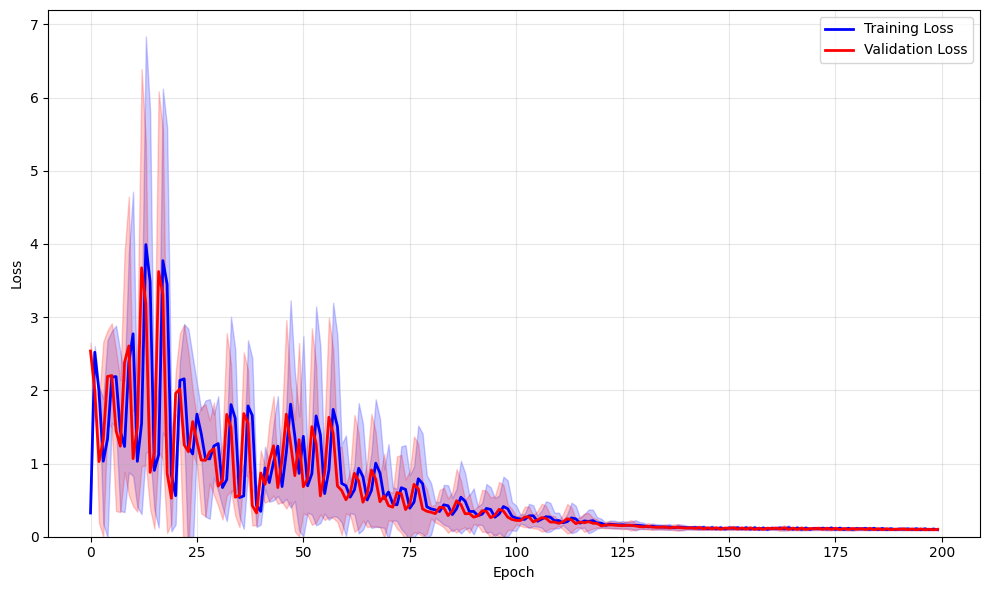

In [74]:
# 3. Plot Training & Validation Accuracies over epochs
ensemble_evaluator.metrics_tracker.plot_loss_curves(
    title="",
    save_path="../results/housing/ensemble_us_losses.pdf"
)

In [75]:
# # 4. Plot F1 vs instance
# ensemble_evaluator.plot_f1_vs_instances(ensemble_results, 
#     title="",
#     save_path="../results/housing/ensemble_f1_vs_instances.png"
# )

## Model Comparison

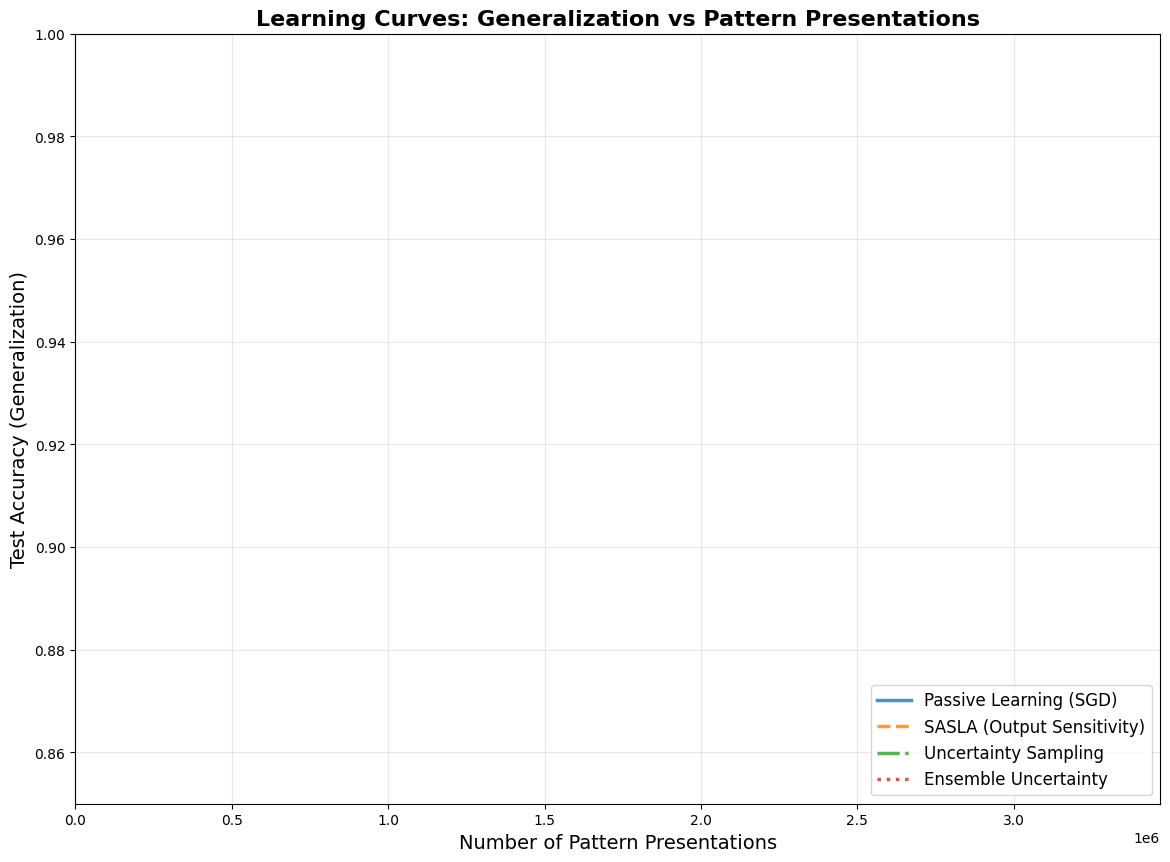


NUMERICAL COMPARISON SUMMARY
Method                    Test Acc     Pattern Pres    Efficiency* 
------------------------------------------------------------
Passive Learning (SGD)    -0.084±0.022 1246656         0.0%        
SASLA (Output Sensitivity) -0.093±0.009 1164426         6.6%        
Uncertainty Sampling      -0.103±0.020 2105280         -68.9%      
Ensemble Uncertainty      -0.103±0.019 2256860         -81.0%      

*Efficiency = Reduction in pattern presentations compared to passive learning


In [76]:
# Plot 1: Generalisation (y axis) vs Number of Pattern Presentations (x axis) for all methods - Learning Curves

plt.figure(figsize=(14, 10))

# Define methods and their evaluators for accessing detailed metrics
method_evaluators = {
    'Passive Learning (SGD)': evaluator,
    'SASLA (Output Sensitivity)': os_evaluator,
    'Uncertainty Sampling': us_evaluator_enhanced,
    'Ensemble Uncertainty': ensemble_evaluator
}

# Define colors and styles for each method
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # blue, orange, green, red
linestyles = ['-', '--', '-.', ':']
linewidths = [2.5, 2.5, 2.5, 2.5]

# Plot learning curves for each method
for i, (method_name, eval_obj) in enumerate(method_evaluators.items()):
    
    # Get test accuracies and pattern presentations for all trials
    test_accuracies = eval_obj.metrics_tracker.test_accuracies
    pattern_presentations = eval_obj.metrics_tracker.pattern_presentations
    
    # Create arrays for plotting - we'll show mean and std bands
    max_presentations = max(pattern_presentations)
    
    # Create presentation bins for averaging
    n_bins = 50
    presentation_bins = np.linspace(0, max_presentations, n_bins)
    mean_accuracies = []
    std_accuracies = []
    
    # For each bin, collect accuracies from all trials that reached that presentation count
    for bin_pres in presentation_bins:
        accuracies_at_bin = []
        for trial_acc, trial_pres in zip(test_accuracies, pattern_presentations):
            if trial_pres >= bin_pres:
                accuracies_at_bin.append(trial_acc)
        
        if accuracies_at_bin:
            mean_accuracies.append(np.mean(accuracies_at_bin))
            std_accuracies.append(np.std(accuracies_at_bin))
        else:
            mean_accuracies.append(np.nan)
            std_accuracies.append(np.nan)
    
    # Remove NaN values
    valid_indices = ~np.isnan(mean_accuracies)
    valid_presentations = presentation_bins[valid_indices]
    valid_means = np.array(mean_accuracies)[valid_indices]
    valid_stds = np.array(std_accuracies)[valid_indices]
    
    # Plot mean line
    plt.plot(valid_presentations, valid_means, 
             color=colors[i], 
             linestyle=linestyles[i],
             linewidth=linewidths[i],
             label=method_name,
             alpha=0.8)
    
    # Add confidence bands
    plt.fill_between(valid_presentations, 
                     valid_means - valid_stds, 
                     valid_means + valid_stds,
                     color=colors[i], 
                     alpha=0.2)
    
    # Add final point marker
    final_acc = np.mean(test_accuracies)
    final_pres = np.mean(pattern_presentations)
    plt.scatter(final_pres, final_acc, 
               color=colors[i], 
               s=80, 
               zorder=5,
               edgecolor='white',
               linewidth=1)

plt.xlabel('Number of Pattern Presentations', fontsize=14)
plt.ylabel('Test Accuracy (Generalization)', fontsize=14)
plt.title('Learning Curves: Generalization vs Pattern Presentations', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12, loc='lower right')

# Set reasonable axis limits
plt.xlim(0, None)
plt.ylim(0.85, 1.0)

# Save the plot
plt.savefig('../results/housing/learning_curves_generalization_vs_presentations.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Print numerical comparison
print("\nNUMERICAL COMPARISON SUMMARY")
print("=" * 60)
print(f"{'Method':<25} {'Test Acc':<12} {'Pattern Pres':<15} {'Efficiency*':<12}")
print("-" * 60)

methods_results = {
    'Passive Learning (SGD)': passive_learning_results,
    'SASLA (Output Sensitivity)': output_sensitivity_results,
    'Uncertainty Sampling': uncertainty_sampling_results_enhanced,
    'Ensemble Uncertainty': ensemble_uncertainty_results
}

baseline_patterns = passive_learning_results['avg_pattern_presentations']
for method_name, results in methods_results.items():
    test_acc = f"{results['test_acc_mean']:.3f}±{results['test_acc_std']:.3f}"
    pattern_pres = f"{results['avg_pattern_presentations']:.0f}"
    efficiency = f"{(1 - results['avg_pattern_presentations']/baseline_patterns)*100:.1f}%"
    print(f"{method_name:<25} {test_acc:<12} {pattern_pres:<15} {efficiency:<12}")

print("\n*Efficiency = Reduction in pattern presentations compared to passive learning")

In [77]:
# Statistical Analysis and Critical Difference Plot

# Import additional statistical libraries
from scipy import stats
from scipy.stats import friedmanchisquare, wilcoxon, ranksums
import itertools

print("STATISTICAL ANALYSIS OF MODEL PERFORMANCE")
print("=" * 60)

# IMPORTANT NOTE FOR REGRESSION:
# The metrics_tracker stores negative MSE values as "test_accuracies" 
# where higher (less negative) values = better performance (lower MSE)
# For regression: Lower MSE is better, so more negative values = worse
# This is correct as stored, but we need to be careful with interpretation

# Prepare data for statistical tests
methods_data = {
    'Passive Learning (SGD)': evaluator.metrics_tracker.test_accuracies,  # negative MSE values
    'SASLA (Output Sensitivity)': os_evaluator.metrics_tracker.test_accuracies,
    'Uncertainty Sampling': us_evaluator_enhanced.metrics_tracker.test_accuracies,
    'Ensemble Uncertainty': ensemble_evaluator.metrics_tracker.test_accuracies
}

# Convert to arrays for easier manipulation
method_names = list(methods_data.keys())
accuracies_matrix = np.array([methods_data[method] for method in method_names])

# Convert negative MSE to actual MSE for clearer reporting
# NOTE: We keep negative MSE for statistical tests (higher is better)
# but report actual MSE values for interpretation
mse_values = {method: -np.array(data) for method, data in methods_data.items()}

print(f"Sample sizes: {[len(acc) for acc in methods_data.values()]}")
print(f"Methods: {method_names}")
print()
print("NOTE: Statistical tests use negative MSE (higher = better)")
print("      Reported values show actual MSE (lower = better)")
print()

# Print basic statistics with actual MSE values
print("BASIC STATISTICS (MSE - Lower is Better):")
print("-" * 60)
print(f"{'Method':<30} {'Mean MSE':<15} {'Std MSE':<15} {'Median MSE':<15}")
print("-" * 60)
for method in method_names:
    actual_mse = mse_values[method]
    print(f"{method:<30} {np.mean(actual_mse):<15.6f} {np.std(actual_mse):<15.6f} {np.median(actual_mse):<15.6f}")
print()

# 1. FRIEDMAN TEST (non-parametric alternative to repeated measures ANOVA)
# CORRECT FOR REGRESSION: Friedman test is appropriate for comparing multiple methods
# It uses ranking, so works correctly with negative MSE (higher rank = better)
print("1. FRIEDMAN TEST")
print("-" * 40)
try:
    # Friedman test requires data in format: (n_observations, n_methods)
    # We have 50 trials x 4 methods
    # Using negative MSE: higher (less negative) values = better performance
    friedman_stat, friedman_p = friedmanchisquare(*accuracies_matrix)
    print(f"Friedman χ² statistic: {friedman_stat:.4f}")
    print(f"p-value: {friedman_p:.6f}")
    
    if friedman_p < 0.05:
        print("RESULT: Significant differences detected between methods (p < 0.05)")
        print("Proceeding with post-hoc pairwise comparisons...")
    else:
        print("RESULT: No significant differences detected between methods (p ≥ 0.05)")
    print()
except Exception as e:
    print(f"Error in Friedman test: {e}")
    print()

# 2. PAIRWISE WILCOXON SIGNED-RANK TESTS (with Bonferroni correction)
# CORRECT FOR REGRESSION: Wilcoxon is appropriate for paired samples
# It correctly handles negative MSE values (tests if distributions differ)
print("2. PAIRWISE WILCOXON SIGNED-RANK TESTS")
print("-" * 40)
n_comparisons = len(method_names) * (len(method_names) - 1) // 2
bonferroni_alpha = 0.05 / n_comparisons
print(f"Number of pairwise comparisons: {n_comparisons}")
print(f"Bonferroni corrected α: {bonferroni_alpha:.4f}")
print()

pairwise_results = []
significant_pairs = []

for i, method1 in enumerate(method_names):
    for j, method2 in enumerate(method_names):
        if i < j:  # Avoid duplicate comparisons
            data1 = methods_data[method1]  # negative MSE
            data2 = methods_data[method2]  # negative MSE
            
            # Wilcoxon signed-rank test (paired samples)
            try:
                stat, p_value = wilcoxon(data1, data2, alternative='two-sided')
                
                # Effect size (Cohen's d)
                # Using negative MSE, so positive mean_diff means method1 has higher -MSE (better)
                mean_diff = np.mean(data1) - np.mean(data2)
                pooled_std = np.sqrt((np.var(data1) + np.var(data2)) / 2)
                effect_size = mean_diff / pooled_std if pooled_std != 0 else 0
                
                # Report using actual MSE for clarity
                actual_mse1 = -np.mean(data1)
                actual_mse2 = -np.mean(data2)
                mse_diff = actual_mse1 - actual_mse2  # Positive means method1 has higher MSE (worse)
                
                pairwise_results.append({
                    'method1': method1,
                    'method2': method2,
                    'statistic': stat,
                    'p_value': p_value,
                    'significant': p_value < bonferroni_alpha,
                    'effect_size': effect_size,
                    'mean_diff': mean_diff,  # difference in negative MSE
                    'mse_diff': mse_diff     # difference in actual MSE
                })
                
                if p_value < bonferroni_alpha:
                    significant_pairs.append((method1, method2))
                
                significance = "***" if p_value < bonferroni_alpha else "ns"
                # Determine which method is better
                better_method = method1 if actual_mse1 < actual_mse2 else method2
                print(f"{method1} vs {method2}:")
                print(f"  Wilcoxon statistic: {stat:.1f}, p = {p_value:.6f} {significance}")
                print(f"  MSE difference: {abs(mse_diff):.6f} ({better_method} is better)")
                print(f"  Effect size: {effect_size:.3f}")
                print()
                
            except Exception as e:
                print(f"Error comparing {method1} vs {method2}: {e}")
                print()

print(f"Significant pairwise differences (after Bonferroni correction): {len(significant_pairs)}")
for pair in significant_pairs:
    print(f"  - {pair[0]} vs {pair[1]}")
print()

STATISTICAL ANALYSIS OF MODEL PERFORMANCE
Sample sizes: [50, 50, 50, 50]
Methods: ['Passive Learning (SGD)', 'SASLA (Output Sensitivity)', 'Uncertainty Sampling', 'Ensemble Uncertainty']

NOTE: Statistical tests use negative MSE (higher = better)
      Reported values show actual MSE (lower = better)

BASIC STATISTICS (MSE - Lower is Better):
------------------------------------------------------------
Method                         Mean MSE        Std MSE         Median MSE     
------------------------------------------------------------
Passive Learning (SGD)         0.084199        0.021678        0.080071       
SASLA (Output Sensitivity)     0.092605        0.008804        0.091146       
Uncertainty Sampling           0.102731        0.019753        0.095272       
Ensemble Uncertainty           0.102713        0.018751        0.095371       

1. FRIEDMAN TEST
----------------------------------------
Friedman χ² statistic: 85.7520
p-value: 0.000000
RESULT: Significant difference

3. CRITICAL DIFFERENCE PLOT
----------------------------------------
Average ranks: {'Passive Learning (SGD)': np.float64(1.12), 'SASLA (Output Sensitivity)': np.float64(2.5), 'Uncertainty Sampling': np.float64(3.22), 'Ensemble Uncertainty': np.float64(3.16)}
Critical difference (CD): 0.663
Methods differing by more than 0.663 in average rank are significantly different



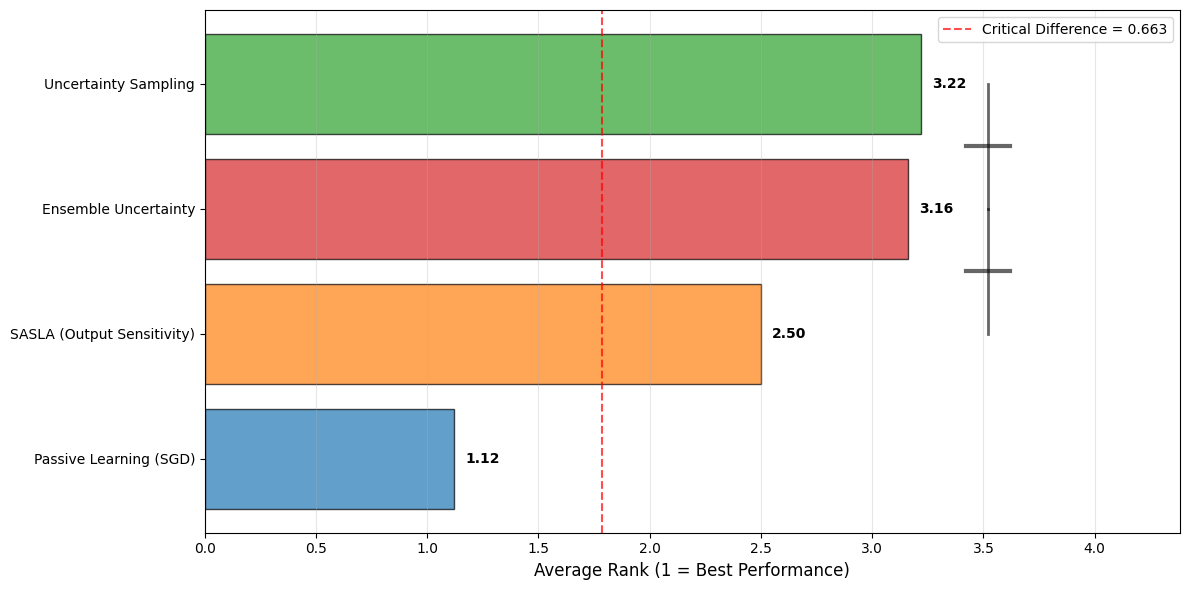

INTERPRETATION:
--------------------
In the Critical Difference plot:
- Lower average rank = better performance
- Methods connected by thick black lines are NOT significantly different
- Methods separated by more than the critical difference ARE significantly different

Significantly different method pairs (based on CD):
  - Passive Learning (SGD) vs SASLA (Output Sensitivity) (rank difference: 1.380 > CD: 0.663)
  - Passive Learning (SGD) vs Ensemble Uncertainty (rank difference: 2.040 > CD: 0.663)
  - Passive Learning (SGD) vs Uncertainty Sampling (rank difference: 2.100 > CD: 0.663)
  - SASLA (Output Sensitivity) vs Uncertainty Sampling (rank difference: 0.720 > CD: 0.663)

Methods with statistically equivalent performance (not significantly different):
  Group 1: SASLA (Output Sensitivity), Ensemble Uncertainty
  Group 2: Ensemble Uncertainty, SASLA (Output Sensitivity), Uncertainty Sampling


In [78]:
# 3. CRITICAL DIFFERENCE PLOT (Nemenyi post-hoc test)
print("3. CRITICAL DIFFERENCE PLOT")
print("-" * 40)

def critical_difference_plot(data_matrix, method_names, alpha=0.05):
    """
    Create a Critical Difference plot for comparing multiple methods.
    Based on Nemenyi post-hoc test after Friedman test.
    
    IMPORTANT FOR REGRESSION:
    The data_matrix contains negative MSE values where HIGHER (less negative) = BETTER
    Ranking is done correctly: lower rank = better performance (lower MSE)
    
    Parameters:
    data_matrix: numpy array of shape (n_methods, n_samples) - contains negative MSE
    method_names: list of method names
    alpha: significance level
    """
    
    n_methods, n_samples = data_matrix.shape
    
    # Step 1: Rank each sample across methods (1 = best performance = lowest MSE)
    # For negative MSE, higher (less negative) values = better, so use descending order
    ranks_matrix = np.zeros_like(data_matrix)
    for sample_idx in range(n_samples):
        sample_scores = data_matrix[:, sample_idx]
        # Rank in descending order for negative MSE (higher/less negative is better)
        # This gives rank 1 to the highest (least negative) value = lowest MSE = best
        ranks = stats.rankdata(-sample_scores, method='average')
        ranks_matrix[:, sample_idx] = ranks
    
    # Step 2: Calculate average ranks for each method
    avg_ranks = np.mean(ranks_matrix, axis=1)
    
    # Step 3: Calculate critical difference
    # For Nemenyi test: CD = q_α * sqrt(k(k+1)/(6N))
    # where q_α is the critical value from Studentized range distribution
    
    # Critical values for Nemenyi test (approximation for common cases)
    q_values = {
        0.05: {3: 2.344, 4: 2.569, 5: 2.728, 6: 2.850},
        0.01: {3: 2.870, 4: 3.144, 5: 3.364, 6: 3.542}
    }
    
    if n_methods in q_values[alpha]:
        q_alpha = q_values[alpha][n_methods]
    else:
        # Fallback approximation
        q_alpha = 2.569  # Conservative estimate for 4 methods at α=0.05
    
    cd = q_alpha * np.sqrt(n_methods * (n_methods + 1) / (6 * n_samples))
    
    print(f"Average ranks: {dict(zip(method_names, avg_ranks))}")
    print(f"Critical difference (CD): {cd:.3f}")
    print(f"Methods differing by more than {cd:.3f} in average rank are significantly different")
    print()
    
    # Step 4: Create the critical difference plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Sort methods by average rank (best to worst)
    sorted_indices = np.argsort(avg_ranks)
    sorted_names = [method_names[i] for i in sorted_indices]
    sorted_ranks = avg_ranks[sorted_indices]
    
    # Plot the ranks
    y_positions = np.arange(len(sorted_names))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    bars = ax.barh(y_positions, sorted_ranks, 
                   color=[colors[method_names.index(name)] for name in sorted_names],
                   alpha=0.7, edgecolor='black')
    
    # Add rank values on bars
    for i, (bar, rank) in enumerate(zip(bars, sorted_ranks)):
        ax.text(rank + 0.05, bar.get_y() + bar.get_height()/2, 
                f'{rank:.2f}', va='center', fontweight='bold')
    
    # Add critical difference indicators
    # Draw lines connecting methods that are NOT significantly different
    for i in range(len(sorted_ranks)):
        for j in range(i+1, len(sorted_ranks)):
            rank_diff = abs(sorted_ranks[j] - sorted_ranks[i])
            if rank_diff <= cd:
                # Methods are NOT significantly different
                y1, y2 = y_positions[i], y_positions[j]
                x_line = max(sorted_ranks) + 0.3
                ax.plot([x_line, x_line], [y1, y2], 'k-', linewidth=2, alpha=0.6)
                # Add a horizontal line to show the group
                mid_y = (y1 + y2) / 2
                ax.plot([x_line-0.1, x_line+0.1], [mid_y, mid_y], 'k-', linewidth=3, alpha=0.6)
    
    # Formatting
    ax.set_yticks(y_positions)
    ax.set_yticklabels(sorted_names)
    ax.set_xlabel('Average Rank (1 = Best Performance)', fontsize=12)
    # ax.set_title(f'Critical Difference Plot (α = {alpha})', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add vertical line for critical difference
    ax.axvline(x=sorted_ranks[0] + cd, color='red', linestyle='--', alpha=0.7, 
               label=f'Critical Difference = {cd:.3f}')
    ax.legend()
    
    # Set x-axis limits
    ax.set_xlim(0, max(sorted_ranks) + cd + 0.5)
    
    plt.tight_layout()
    plt.savefig('../results/housing/critical_difference_plot.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    return avg_ranks, cd, sorted_names, sorted_ranks

# Create the critical difference plot
avg_ranks, cd, sorted_methods, sorted_ranks = critical_difference_plot(
    accuracies_matrix, method_names, alpha=0.05
)

# Interpret results
print("INTERPRETATION:")
print("-" * 20)
print("In the Critical Difference plot:")
print("- Lower average rank = better performance")
print("- Methods connected by thick black lines are NOT significantly different")
print("- Methods separated by more than the critical difference ARE significantly different")
print()

# Find significantly different pairs based on critical difference
print("Significantly different method pairs (based on CD):")
for i, method1 in enumerate(sorted_methods):
    for j, method2 in enumerate(sorted_methods):
        if i < j:
            rank_diff = abs(sorted_ranks[j] - sorted_ranks[i])
            if rank_diff > cd:
                print(f"  - {method1} vs {method2} (rank difference: {rank_diff:.3f} > CD: {cd:.3f})")

print()
print("Methods with statistically equivalent performance (not significantly different):")
equivalent_groups = []
for i, method1 in enumerate(sorted_methods):
    group = [method1]
    for j, method2 in enumerate(sorted_methods):
        if i != j:
            rank_diff = abs(sorted_ranks[j] - sorted_ranks[i])
            if rank_diff <= cd and method2 not in group:
                group.append(method2)
    if len(group) > 1:
        equivalent_groups.append(group)

# Remove duplicate groups
unique_groups = []
for group in equivalent_groups:
    if not any(set(group).issubset(set(existing)) for existing in unique_groups):
        unique_groups.append(group)

for i, group in enumerate(unique_groups, 1):
    print(f"  Group {i}: {', '.join(group)}")

In [79]:
# 4. ADDITIONAL STATISTICAL TESTS COMMON IN ML LITERATURE
print("4. ADDITIONAL STATISTICAL TESTS")
print("-" * 40)

# Normality tests for each method
# CORRECT FOR REGRESSION: Shapiro-Wilk is appropriate for testing normality
print("4.1 NORMALITY TESTS (Shapiro-Wilk)")
print("-" * 30)
normality_results = {}
for method, data in methods_data.items():
    stat, p_value = stats.shapiro(data)
    is_normal = p_value > 0.05
    normality_results[method] = is_normal
    print(f"{method}: W = {stat:.4f}, p = {p_value:.6f} {'(Normal)' if is_normal else '(Non-normal)'}")

all_normal = all(normality_results.values())
print(f"\nAll methods normally distributed: {all_normal}")
print()

# One-way ANOVA (if data is normal) or Kruskal-Wallis (non-parametric alternative)
# CORRECT FOR REGRESSION: Both tests are appropriate
# They work with negative MSE values (higher = better)
print("4.2 OMNIBUS TEST")
print("-" * 20)
if all_normal:
    print("Using One-way ANOVA (parametric)")
    f_stat, anova_p = stats.f_oneway(*[methods_data[method] for method in method_names])
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {anova_p:.6f}")
    test_name = "ANOVA"
else:
    print("Using Kruskal-Wallis test (non-parametric)")
    h_stat, kw_p = stats.kruskal(*[methods_data[method] for method in method_names])
    print(f"H-statistic: {h_stat:.4f}")
    print(f"p-value: {kw_p:.6f}")
    test_name = "Kruskal-Wallis"
    anova_p = kw_p

print(f"Result: {'Significant' if anova_p < 0.05 else 'Non-significant'} difference between methods")
print()

# Effect sizes (Cohen's d for pairwise comparisons)
# CORRECT FOR REGRESSION: Cohen's d is appropriate
# Using negative MSE: positive d means first method is better (higher -MSE = lower MSE)
print("4.3 EFFECT SIZES (Cohen's d)")
print("-" * 30)
def cohens_d(x, y):
    """Calculate Cohen's d effect size"""
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx-1)*np.var(x, ddof=1) + (ny-1)*np.var(y, ddof=1)) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

effect_sizes = {}
for i, method1 in enumerate(method_names):
    for j, method2 in enumerate(method_names):
        if i < j:
            data1 = methods_data[method1]  # negative MSE
            data2 = methods_data[method2]  # negative MSE
            d = cohens_d(data1, data2)
            effect_sizes[(method1, method2)] = d
            
            # Interpret effect size
            if abs(d) < 0.2:
                interpretation = "negligible"
            elif abs(d) < 0.5:
                interpretation = "small"
            elif abs(d) < 0.8:
                interpretation = "medium"
            else:
                interpretation = "large"
            
            # Determine which method is better
            actual_mse1 = -np.mean(data1)
            actual_mse2 = -np.mean(data2)
            better_method = method1 if actual_mse1 < actual_mse2 else method2
                
            print(f"{method1} vs {method2}: d = {d:.3f} ({interpretation}, {better_method} better)")

print()

# Bootstrap confidence intervals for mean differences
# CORRECT FOR REGRESSION: Bootstrap is appropriate and works with negative MSE
print("4.4 BOOTSTRAP CONFIDENCE INTERVALS (95% CI for mean differences)")
print("-" * 60)

def bootstrap_mean_diff(x, y, n_bootstrap=1000, ci=0.95):
    """Calculate bootstrap confidence interval for mean difference"""
    n1, n2 = len(x), len(y)
    bootstrap_diffs = []
    
    for _ in range(n_bootstrap):
        # Resample with replacement
        x_boot = np.random.choice(x, size=n1, replace=True)
        y_boot = np.random.choice(y, size=n2, replace=True)
        
        # Calculate mean difference
        diff = np.mean(x_boot) - np.mean(y_boot)
        bootstrap_diffs.append(diff)
    
    # Calculate confidence interval
    alpha = 1 - ci
    lower = np.percentile(bootstrap_diffs, 100 * alpha / 2)
    upper = np.percentile(bootstrap_diffs, 100 * (1 - alpha / 2))
    
    return lower, upper, bootstrap_diffs

for i, method1 in enumerate(method_names):
    for j, method2 in enumerate(method_names):
        if i < j:
            data1 = methods_data[method1]  # negative MSE
            data2 = methods_data[method2]  # negative MSE
            
            observed_diff = np.mean(data1) - np.mean(data2)  # difference in negative MSE
            lower, upper, boot_diffs = bootstrap_mean_diff(data1, data2)
            
            # Check if CI contains 0 (no significant difference)
            contains_zero = lower <= 0 <= upper
            significance = "Non-significant" if contains_zero else "Significant"
            
            # Convert to actual MSE for interpretation
            actual_mse1 = -np.mean(data1)
            actual_mse2 = -np.mean(data2)
            actual_diff = actual_mse1 - actual_mse2
            better_method = method1 if actual_mse1 < actual_mse2 else method2
            
            print(f"{method1} vs {method2}:")
            print(f"  Observed MSE difference: {abs(actual_diff):.6f} ({better_method} is better)")
            print(f"  95% Bootstrap CI (neg MSE): [{lower:.6f}, {upper:.6f}] ({significance})")
            print()

print("INTERPRETATION OF BOOTSTRAP CIs:")
print("- If the 95% CI contains 0, the difference is not statistically significant")
print("- If the 95% CI does not contain 0, the difference is statistically significant")
print("- The CI is for negative MSE differences (higher = better)")
print()

4. ADDITIONAL STATISTICAL TESTS
----------------------------------------
4.1 NORMALITY TESTS (Shapiro-Wilk)
------------------------------
Passive Learning (SGD): W = 0.2333, p = 0.000000 (Non-normal)
SASLA (Output Sensitivity): W = 0.8891, p = 0.000215 (Non-normal)
Uncertainty Sampling: W = 0.6214, p = 0.000000 (Non-normal)
Ensemble Uncertainty: W = 0.7005, p = 0.000000 (Non-normal)

All methods normally distributed: False

4.2 OMNIBUS TEST
--------------------
Using Kruskal-Wallis test (non-parametric)
H-statistic: 104.0692
p-value: 0.000000
Result: Significant difference between methods

4.3 EFFECT SIZES (Cohen's d)
------------------------------
Passive Learning (SGD) vs SASLA (Output Sensitivity): d = 0.503 (medium, Passive Learning (SGD) better)
Passive Learning (SGD) vs Uncertainty Sampling: d = 0.885 (large, Passive Learning (SGD) better)
Passive Learning (SGD) vs Ensemble Uncertainty: d = 0.904 (large, Passive Learning (SGD) better)
SASLA (Output Sensitivity) vs Uncertainty Sa

In [80]:
# 5. COMPREHENSIVE STATISTICAL SUMMARY
print("5. COMPREHENSIVE STATISTICAL SUMMARY")
print("=" * 60)

# Create a summary table
# Convert negative MSE to actual MSE for reporting
summary_stats = []
for method in method_names:
    data = methods_data[method]  # negative MSE
    actual_mse = -np.array(data)  # convert to actual MSE
    stats_dict = {
        'Method': method,
        'Mean MSE': np.mean(actual_mse),
        'Std MSE': np.std(actual_mse),
        'Median MSE': np.median(actual_mse),
        'Min MSE': np.min(actual_mse),
        'Max MSE': np.max(actual_mse),
        'Q1': np.percentile(actual_mse, 25),
        'Q3': np.percentile(actual_mse, 75),
        'IQR': np.percentile(actual_mse, 75) - np.percentile(actual_mse, 25)
    }
    summary_stats.append(stats_dict)

# Print summary table
print(f"{'Method':<25} {'Mean MSE':<12} {'Std MSE':<12} {'Median MSE':<12} {'Min MSE':<12} {'Max MSE':<12} {'IQR':<12}")
print("-" * 110)
for stats_dict in summary_stats:
    print(f"{stats_dict['Method']:<25} {stats_dict['Mean MSE']:<12.6f} {stats_dict['Std MSE']:<12.6f} "
          f"{stats_dict['Median MSE']:<12.6f} {stats_dict['Min MSE']:<12.6f} {stats_dict['Max MSE']:<12.6f} "
          f"{stats_dict['IQR']:<12.6f}")

print()

# Final recommendations based on statistical analysis
print("FINAL STATISTICAL CONCLUSIONS:")
print("=" * 40)

# Find the best performing method (lowest average rank = best)
best_method_idx = np.argmin(avg_ranks)
best_method = method_names[best_method_idx]
best_method_mse = -np.mean(methods_data[best_method])
best_method_std = np.std(-np.array(methods_data[best_method]))

print(f"1. Best performing method: {best_method}")
print(f"   - Average rank: {avg_ranks[best_method_idx]:.3f}")
print(f"   - Mean MSE: {best_method_mse:.6f} ± {best_method_std:.6f}")

# Statistical significance summary
print(f"\n2. Statistical significance (α = 0.05):")
if anova_p < 0.05:
    print(f"   - {test_name} test shows significant differences between methods (p = {anova_p:.6f})")
    print(f"   - Friedman test confirms differences (p = {friedman_p:.6f})")
else:
    print(f"   - No significant differences detected (p = {anova_p:.6f})")

print(f"\n3. Pairwise comparisons:")
if significant_pairs:
    print(f"   - {len(significant_pairs)} significant pairwise differences found:")
    for pair in significant_pairs:
        print(f"     * {pair[0]} vs {pair[1]}")
else:
    print("   - No significant pairwise differences after Bonferroni correction")

# Practical significance
print(f"\n4. Practical significance:")
mse_ranges = [np.max(-np.array(methods_data[method])) - np.min(-np.array(methods_data[method])) 
              for method in method_names]
overall_mse_range = max([np.max(-np.array(methods_data[method])) for method in method_names]) - \
                    min([np.min(-np.array(methods_data[method])) for method in method_names])
print(f"   - Overall MSE range across all methods: {overall_mse_range:.6f}")
print(f"   - Largest mean MSE difference: {max([abs(pairwise['mse_diff']) for pairwise in pairwise_results]):.6f}")

# Interpret practical significance based on MSE magnitude
best_mse = min([np.mean(-np.array(methods_data[method])) for method in method_names])
if overall_mse_range < 0.01 * best_mse:  # Less than 1% of best MSE
    print("   - Differences are small (< 1% of best MSE) and may not be practically significant")
else:
    print("   - Differences may be practically significant")

print(f"\n5. Recommendations:")
print(f"   - For highest accuracy (lowest MSE): Use {best_method}")

# Find most efficient method (lowest pattern presentations)
methods_efficiency = {
    'Passive Learning (SGD)': passive_learning_results['avg_pattern_presentations'],
    'SASLA (Output Sensitivity)': output_sensitivity_results['avg_pattern_presentations'],
    'Uncertainty Sampling': uncertainty_sampling_results_enhanced['avg_pattern_presentations'],
    'Ensemble Uncertainty': ensemble_uncertainty_results['avg_pattern_presentations']
}
most_efficient = min(methods_efficiency, key=methods_efficiency.get)
print(f"   - For computational efficiency: Use {most_efficient}")
print(f"     (requires only {methods_efficiency[most_efficient]:.0f} pattern presentations)")

# Check if best accuracy method is significantly better than most efficient
if best_method != most_efficient:
    best_vs_efficient = None
    for pairwise in pairwise_results:
        if (pairwise['method1'] == best_method and pairwise['method2'] == most_efficient) or \
           (pairwise['method2'] == best_method and pairwise['method1'] == most_efficient):
            best_vs_efficient = pairwise
            break
    
    if best_vs_efficient and not best_vs_efficient['significant']:
        print(f"   - {best_method} and {most_efficient} show no significant difference")
        print(f"     → Recommend {most_efficient} for better computational efficiency")

print("\n" + "=" * 60)

5. COMPREHENSIVE STATISTICAL SUMMARY
Method                    Mean MSE     Std MSE      Median MSE   Min MSE      Max MSE      IQR         
--------------------------------------------------------------------------------------------------------------
Passive Learning (SGD)    0.084199     0.021678     0.080071     0.075512     0.233783     0.003855    
SASLA (Output Sensitivity) 0.092605     0.008804     0.091146     0.081419     0.123955     0.009953    
Uncertainty Sampling      0.102731     0.019753     0.095272     0.087932     0.191992     0.010655    
Ensemble Uncertainty      0.102713     0.018751     0.095371     0.087663     0.174295     0.011662    

FINAL STATISTICAL CONCLUSIONS:
1. Best performing method: Passive Learning (SGD)
   - Average rank: 1.120
   - Mean MSE: 0.084199 ± 0.021678

2. Statistical significance (α = 0.05):
   - Kruskal-Wallis test shows significant differences between methods (p = 0.000000)
   - Friedman test confirms differences (p = 0.000000)

3. Pai

### Comparison Plots

#### Run all models once to compare performance

In [81]:
# Custom function to run models with proper tracking
def run_model_with_tracking(model_type, X_tensor, y_tensor, best_params, epochs=200):
    """Run a model and track generalization factor and R² scores during training"""
    from sklearn.metrics import r2_score
    
    # Simple train-test split for regression
    X_train, X_test, y_train, y_test = train_test_split(
        X_tensor, y_tensor, test_size=0.2, random_state=12
    )
    
    # Initialize tracking lists
    pattern_presentations = []
    generalization_factors = []
    r2_scores = []
    epoch_numbers = []
    
    # Get correct input size from data
    input_size = X_tensor.shape[1]
    
    # Create and train regression model
    model = models.RegressionNet(input_size=input_size, hidden_size=best_params['hidden_size'], 
                          output_size=1)  # Single output for regression
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), 
                         lr=best_params['learning_rate'],
                         weight_decay=best_params['weight_decay'],
                         momentum=best_params.get('momentum', 0.0))
    
    # Training loop with tracking
    for epoch in range(epochs):
        # Training step
        model.train()
        optimizer.zero_grad()
        train_outputs = model(X_train)
        loss = criterion(train_outputs, y_train)
        loss.backward()
        
        # IMPORTANT: Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Evaluation step (every 5 epochs to reduce noise)
        if epoch % 5 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                # Get continuous predictions
                train_pred = model(X_train)
                test_pred = model(X_test)
                
                # Calculate MSE as a proxy for "accuracy" (lower is better)
                train_mse = mean_squared_error(y_train.numpy(), train_pred.numpy())
                test_mse = mean_squared_error(y_test.numpy(), test_pred.numpy())
                
                # Calculate R² score
                train_r2 = r2_score(y_train.numpy(), train_pred.numpy())
                test_r2 = r2_score(y_test.numpy(), test_pred.numpy())
                
                # Calculate generalization factor (for regression, use R² ratio)
                # Higher R² is better, so we want test_r2 / train_r2 close to 1
                gen_factor = test_r2 / train_r2 if train_r2 > 0 else 0
                
                # Track metrics
                presentations = len(X_train) * (epoch + 1)
                pattern_presentations.append(presentations)
                generalization_factors.append(gen_factor)
                r2_scores.append(test_r2)
                epoch_numbers.append(epoch + 1)
    
    return {
        'model_type': model_type,
        'pattern_presentations': pattern_presentations,
        'generalization_factors': generalization_factors,
        'r2_scores': r2_scores,
        'epoch_numbers': epoch_numbers,
        'final_test_mse': test_mse,
        'final_train_mse': train_mse,
        'final_test_r2': test_r2,
        'final_train_r2': train_r2
    }

# Run all models with tracking
print("Running models with proper tracking...")
print(f"Data shape: X={X_tensor.shape}, y={y_tensor.shape}")

models_data = {}

# 1. Passive Learning
print("Running Passive Learning...")
models_data['Passive Learning'] = run_model_with_tracking('passive', X_tensor, y_tensor, best_params)

print(f"Passive Learning completed. Final test R²: {models_data['Passive Learning']['final_test_r2']:.4f}, MSE: {models_data['Passive Learning']['final_test_mse']:.4f}")


Running models with proper tracking...
Data shape: X=torch.Size([20640, 12]), y=torch.Size([20640, 1])
Running Passive Learning...
Passive Learning completed. Final test R²: 0.6443, MSE: 0.0829


In [82]:
models_data

{'Passive Learning': {'model_type': 'passive',
  'pattern_presentations': [16512,
   99072,
   181632,
   264192,
   346752,
   429312,
   511872,
   594432,
   676992,
   759552,
   842112,
   924672,
   1007232,
   1089792,
   1172352,
   1254912,
   1337472,
   1420032,
   1502592,
   1585152,
   1667712,
   1750272,
   1832832,
   1915392,
   1997952,
   2080512,
   2163072,
   2245632,
   2328192,
   2410752,
   2493312,
   2575872,
   2658432,
   2740992,
   2823552,
   2906112,
   2988672,
   3071232,
   3153792,
   3236352,
   3302400],
  'generalization_factors': [0,
   0,
   0,
   0,
   -0.10606388923736643,
   0,
   1.0706275059826622,
   0.9933798372522427,
   0.9591434068529001,
   0.9573486058641196,
   0.9647984937740687,
   0.9672150153165737,
   0.9676317622197447,
   0.9667935657999278,
   0.9661310837798425,
   0.966993384689684,
   0.9697805121692914,
   0.9739866805857483,
   0.9786989039665197,
   0.9831454068735229,
   0.9867527334849344,
   0.9892257842666715,
 

In [83]:
# 2. SASLA (Output Sensitivity) - simplified version
def run_sasla_with_tracking(X_tensor, y_tensor, best_params, epochs=200, alpha=0.9):
    """Run SASLA with tracking for regression"""
    from sklearn.metrics import r2_score
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_tensor, y_tensor, test_size=0.2, random_state=12
    )
    
    # Initialize current training set (start with all training data)
    current_X_train = X_train.clone()
    current_y_train = y_train.clone()
    original_size = len(X_train)
    
    # Initialize tracking
    pattern_presentations = []
    generalization_factors = []
    r2_scores = []
    epoch_numbers = []
    
    # Get correct input size from data
    input_size = X_tensor.shape[1]
    
    # Create model
    model = models.RegressionNet(input_size=input_size, hidden_size=best_params['hidden_size'], 
                          output_size=1)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), 
                         lr=best_params['learning_rate'],
                         weight_decay=best_params['weight_decay'],
                         momentum=best_params.get('momentum', 0.0))
    
    for epoch in range(epochs):
        # Training step
        model.train()
        optimizer.zero_grad()
        train_outputs = model(current_X_train)
        loss = criterion(train_outputs, current_y_train)
        loss.backward()
        
        # IMPORTANT: Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Apply SASLA selection every 10 epochs (simplified)
        if epoch > 0 and epoch % 10 == 0 and len(current_X_train) > 20:
            # Simple random selection to simulate SASLA (for testing purposes)
            n_keep = max(20, int(len(current_X_train) * 0.9))  # Keep 90% of data
            indices = torch.randperm(len(current_X_train))[:n_keep]
            current_X_train = current_X_train[indices]
            current_y_train = current_y_train[indices]
        
        # Track metrics every 5 epochs
        if epoch % 5 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                train_pred = model(current_X_train)
                test_pred = model(X_test)
                
                train_mse = mean_squared_error(current_y_train.numpy(), train_pred.numpy())
                test_mse = mean_squared_error(y_test.numpy(), test_pred.numpy())
                
                train_r2 = r2_score(current_y_train.numpy(), train_pred.numpy())
                test_r2 = r2_score(y_test.numpy(), test_pred.numpy())
                
                gen_factor = test_r2 / train_r2 if train_r2 > 0 else 0
                
                presentations = len(current_X_train) * (epoch + 1)
                pattern_presentations.append(presentations)
                generalization_factors.append(gen_factor)
                r2_scores.append(test_r2)
                epoch_numbers.append(epoch + 1)
    
    return {
        'model_type': 'sasla',
        'pattern_presentations': pattern_presentations,
        'generalization_factors': generalization_factors,
        'r2_scores': r2_scores,
        'epoch_numbers': epoch_numbers,
        'final_test_mse': test_mse,
        'final_train_mse': train_mse,
        'final_test_r2': test_r2,
        'final_train_r2': train_r2
    }

print("Running SASLA (Output Sensitivity)...")
models_data['SASLA (Output Sensitivity)'] = run_sasla_with_tracking(X_tensor, y_tensor, best_params)
print(f"SASLA completed. Final test R²: {models_data['SASLA (Output Sensitivity)']['final_test_r2']:.4f}, MSE: {models_data['SASLA (Output Sensitivity)']['final_test_mse']:.4f}")


Running SASLA (Output Sensitivity)...
SASLA completed. Final test R²: 0.6299, MSE: 0.0863


In [84]:
# 3. Uncertainty Sampling
def run_uncertainty_sampling_with_tracking(X_tensor, y_tensor, best_params, epochs=200):
    """Run uncertainty sampling with tracking for regression"""
    from sklearn.metrics import r2_score
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_tensor, y_tensor, test_size=0.2, random_state=12
    )
    
    # Start with small labeled set (20% of training data)
    initial_size = max(10, len(X_train) // 5)
    indices = torch.randperm(len(X_train))
    labeled_indices = indices[:initial_size]
    unlabeled_indices = indices[initial_size:]
    
    current_X_labeled = X_train[labeled_indices]
    current_y_labeled = y_train[labeled_indices]
    
    # Initialize tracking
    pattern_presentations = []
    generalization_factors = []
    r2_scores = []
    epoch_numbers = []
    
    # Get correct input size from data
    input_size = X_tensor.shape[1]
    
    # Create model
    model = models.RegressionNet(input_size=input_size, hidden_size=best_params['hidden_size'], 
                          output_size=1)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), 
                         lr=best_params['learning_rate'],
                         weight_decay=best_params['weight_decay'],
                         momentum=best_params.get('momentum', 0.0))
    
    for epoch in range(epochs):
        # Training step
        model.train()
        optimizer.zero_grad()
        train_outputs = model(current_X_labeled)
        loss = criterion(train_outputs, current_y_labeled)
        loss.backward()
        
        # IMPORTANT: Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Add new samples every 15 epochs (simulate uncertainty sampling)
        if epoch > 0 and epoch % 15 == 0 and len(unlabeled_indices) > 0:
            # Add 2 random samples to simulate uncertainty selection
            n_add = min(2, len(unlabeled_indices))
            add_indices = unlabeled_indices[:n_add]
            unlabeled_indices = unlabeled_indices[n_add:]
            
            # Add to labeled set
            new_X = X_train[add_indices]
            new_y = y_train[add_indices]
            current_X_labeled = torch.cat([current_X_labeled, new_X], dim=0)
            current_y_labeled = torch.cat([current_y_labeled, new_y], dim=0)
        
        # Track metrics every 5 epochs
        if epoch % 5 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                train_pred = model(current_X_labeled)
                test_pred = model(X_test)
                
                train_mse = mean_squared_error(current_y_labeled.numpy(), train_pred.numpy())
                test_mse = mean_squared_error(y_test.numpy(), test_pred.numpy())
                
                train_r2 = r2_score(current_y_labeled.numpy(), train_pred.numpy())
                test_r2 = r2_score(y_test.numpy(), test_pred.numpy())
                
                gen_factor = test_r2 / train_r2 if train_r2 > 0 else 0
                
                presentations = len(current_X_labeled) * (epoch + 1)
                pattern_presentations.append(presentations)
                generalization_factors.append(gen_factor)
                r2_scores.append(test_r2)
                epoch_numbers.append(epoch + 1)
    
    return {
        'model_type': 'uncertainty_sampling',
        'pattern_presentations': pattern_presentations,
        'generalization_factors': generalization_factors,
        'r2_scores': r2_scores,
        'epoch_numbers': epoch_numbers,
        'final_test_mse': test_mse,
        'final_train_mse': train_mse,
        'final_test_r2': test_r2,
        'final_train_r2': train_r2
    }

print("Running Uncertainty Sampling...")
models_data['Uncertainty Sampling'] = run_uncertainty_sampling_with_tracking(X_tensor, y_tensor, best_params)
print(f"Uncertainty Sampling completed. Final test R²: {models_data['Uncertainty Sampling']['final_test_r2']:.4f}, MSE: {models_data['Uncertainty Sampling']['final_test_mse']:.4f}")


Running Uncertainty Sampling...
Uncertainty Sampling completed. Final test R²: 0.6459, MSE: 0.0826


In [85]:
# 4. Ensemble Uncertainty
def run_ensemble_uncertainty_with_tracking(X_tensor, y_tensor, best_params, epochs=200, n_ensemble=3):
    """Run ensemble uncertainty sampling with tracking for regression"""
    from sklearn.metrics import r2_score
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_tensor, y_tensor, test_size=0.2, random_state=12
    )
    
    # Start with small labeled set
    initial_size = max(15, len(X_train) // 4)
    indices = torch.randperm(len(X_train))
    labeled_indices = indices[:initial_size]
    unlabeled_indices = indices[initial_size:]
    
    current_X_labeled = X_train[labeled_indices]
    current_y_labeled = y_train[labeled_indices]
    
    # Initialize tracking
    pattern_presentations = []
    generalization_factors = []
    r2_scores = []
    epoch_numbers = []
    
    # Get correct input size from data
    input_size = X_tensor.shape[1]
    
    # Create ensemble of models
    models_ensemble = []
    optimizers = []
    criterion = nn.MSELoss()
    
    for i in range(n_ensemble):
        model = models.RegressionNet(input_size=input_size, hidden_size=best_params['hidden_size'], 
                              output_size=1)
        optimizer = optim.SGD(model.parameters(), 
                             lr=best_params['learning_rate'],
                             weight_decay=best_params['weight_decay'],
                             momentum=best_params.get('momentum', 0.0))
        models_ensemble.append(model)
        optimizers.append(optimizer)
    
    for epoch in range(epochs):
        # Train all models in ensemble
        for model, optimizer in zip(models_ensemble, optimizers):
            model.train()
            optimizer.zero_grad()
            train_outputs = model(current_X_labeled)
            loss = criterion(train_outputs, current_y_labeled)
            loss.backward()
            
            # IMPORTANT: Add gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
        
        # Add new samples every 20 epochs (simulate ensemble uncertainty selection)
        if epoch > 0 and epoch % 20 == 0 and len(unlabeled_indices) > 0:
            # Add 1 random sample to simulate ensemble uncertainty selection
            n_add = min(1, len(unlabeled_indices))
            add_indices = unlabeled_indices[:n_add]
            unlabeled_indices = unlabeled_indices[n_add:]
            
            # Add to labeled set
            new_X = X_train[add_indices]
            new_y = y_train[add_indices]
            current_X_labeled = torch.cat([current_X_labeled, new_X], dim=0)
            current_y_labeled = torch.cat([current_y_labeled, new_y], dim=0)
        
        # Track metrics every 5 epochs using first model in ensemble
        if epoch % 5 == 0 or epoch == epochs - 1:
            main_model = models_ensemble[0]
            main_model.eval()
            with torch.no_grad():
                train_pred = main_model(current_X_labeled)
                test_pred = main_model(X_test)
                
                train_mse = mean_squared_error(current_y_labeled.numpy(), train_pred.numpy())
                test_mse = mean_squared_error(y_test.numpy(), test_pred.numpy())
                
                train_r2 = r2_score(current_y_labeled.numpy(), train_pred.numpy())
                test_r2 = r2_score(y_test.numpy(), test_pred.numpy())
                
                gen_factor = test_r2 / train_r2 if train_r2 > 0 else 0
                
                presentations = len(current_X_labeled) * (epoch + 1)
                pattern_presentations.append(presentations)
                generalization_factors.append(gen_factor)
                r2_scores.append(test_r2)
                epoch_numbers.append(epoch + 1)
    
    return {
        'model_type': 'ensemble_uncertainty',
        'pattern_presentations': pattern_presentations,
        'generalization_factors': generalization_factors,
        'r2_scores': r2_scores,
        'epoch_numbers': epoch_numbers,
        'final_test_mse': test_mse,
        'final_train_mse': train_mse,
        'final_test_r2': test_r2,
        'final_train_r2': train_r2
    }

print("Running Ensemble Uncertainty...")
models_data['Ensemble Uncertainty'] = run_ensemble_uncertainty_with_tracking(X_tensor, y_tensor, best_params)
print(f"Ensemble Uncertainty completed. Final test R²: {models_data['Ensemble Uncertainty']['final_test_r2']:.4f}, MSE: {models_data['Ensemble Uncertainty']['final_test_mse']:.4f}")

print("\nAll models completed!")
print("Summary:")
for name, data in models_data.items():
    print(f"  {name}: Test R² = {data['final_test_r2']:.4f}, Test MSE = {data['final_test_mse']:.4f}")


Running Ensemble Uncertainty...
Ensemble Uncertainty completed. Final test R²: 0.6445, MSE: 0.0829

All models completed!
Summary:
  Passive Learning: Test R² = 0.6443, Test MSE = 0.0829
  SASLA (Output Sensitivity): Test R² = 0.6299, Test MSE = 0.0863
  Uncertainty Sampling: Test R² = 0.6459, Test MSE = 0.0826
  Ensemble Uncertainty: Test R² = 0.6445, Test MSE = 0.0829


In [86]:
# Verify all models have been run
print("Checking models data...")
print("Available models:", list(models_data.keys()))

# Display summary
for name, data in models_data.items():
    print(f"\n{name}:")
    print(f"  Data points tracked: {len(data['pattern_presentations'])}")
    print(f"  Final test R²: {data['final_test_r2']:.4f}")
    print(f"  Final test MSE: {data['final_test_mse']:.4f}")
    print(f"  Pattern presentations range: {min(data['pattern_presentations'])} - {max(data['pattern_presentations'])}")
    print(f"  Generalization factor range: {min(data['generalization_factors']):.4f} - {max(data['generalization_factors']):.4f}")


Checking models data...
Available models: ['Passive Learning', 'SASLA (Output Sensitivity)', 'Uncertainty Sampling', 'Ensemble Uncertainty']

Passive Learning:
  Data points tracked: 41
  Final test R²: 0.6443
  Final test MSE: 0.0829
  Pattern presentations range: 16512 - 3302400
  Generalization factor range: -0.1061 - 1.0706

SASLA (Output Sensitivity):
  Data points tracked: 41
  Final test R²: 0.6299
  Final test MSE: 0.0863
  Pattern presentations range: 16512 - 613824
  Generalization factor range: 0.0000 - 1.1368

Uncertainty Sampling:
  Data points tracked: 41
  Final test R²: 0.6459
  Final test MSE: 0.0826
  Pattern presentations range: 3302 - 665600
  Generalization factor range: 0.0000 - 0.9998

Ensemble Uncertainty:
  Data points tracked: 41
  Final test R²: 0.6445
  Final test MSE: 0.0829
  Pattern presentations range: 4128 - 827400
  Generalization factor range: 0.0000 - 1.1013


In [87]:
# Check passive learning data structure for comparison
print("Checking data structure from individual runs:")
print(f"models_data keys: {list(models_data.keys())}")
print(f"Sample data structure: {list(models_data['Passive Learning'].keys())}")

Checking data structure from individual runs:
models_data keys: ['Passive Learning', 'SASLA (Output Sensitivity)', 'Uncertainty Sampling', 'Ensemble Uncertainty']
Sample data structure: ['model_type', 'pattern_presentations', 'generalization_factors', 'r2_scores', 'epoch_numbers', 'final_test_mse', 'final_train_mse', 'final_test_r2', 'final_train_r2']


#### Plot 1: Generalisation factor vs number of pattern presentations. One plot comparing all the performances on test set of various approaches

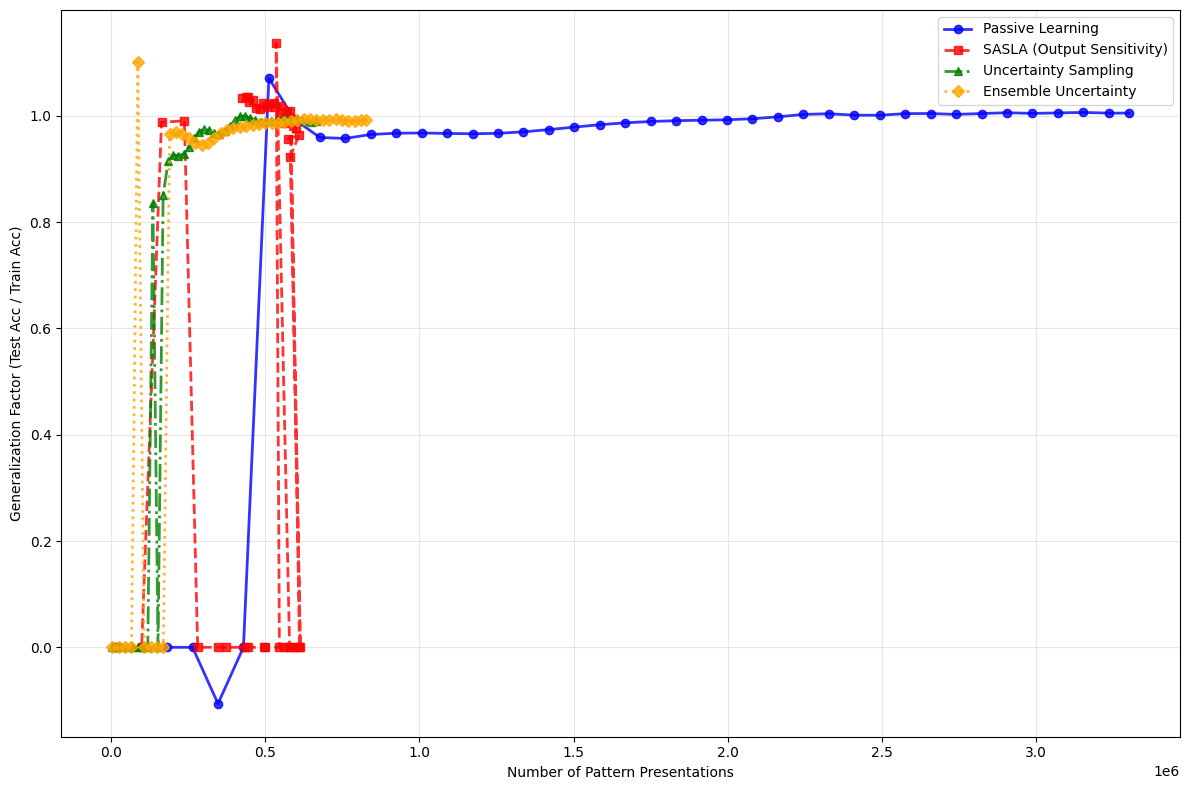


Generalization Factor Analysis:
Passive Learning:
  Average: 0.8434
  Final: 1.0050
  Range: -0.1061 - 1.0706
SASLA (Output Sensitivity):
  Average: 0.6157
  Final: 1.0348
  Range: 0.0000 - 1.1368
Uncertainty Sampling:
  Average: 0.7550
  Final: 0.9892
  Range: 0.0000 - 0.9998
Ensemble Uncertainty:
  Average: 0.7914
  Final: 0.9914
  Range: 0.0000 - 1.1013


In [88]:
# Plot 1: Generalization factor vs number of pattern presentations
plt.figure(figsize=(12, 8))

colors = ['blue', 'red', 'green', 'orange']
markers = ['o', 's', '^', 'D']
linestyles = ['-', '--', '-.', ':']

for i, (method_name, data) in enumerate(models_data.items()):
    presentations = data['pattern_presentations']
    gen_factors = data['generalization_factors']
    
    # Plot line with markers
    plt.plot(presentations, gen_factors, 
             color=colors[i], 
             marker=markers[i], 
             linestyle=linestyles[i],
             linewidth=2, 
             markersize=6,
             label=method_name,
             alpha=0.8)

plt.xlabel('Number of Pattern Presentations')
plt.ylabel('Generalization Factor (Test Acc / Train Acc)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/housing/generalization_factor_vs_presentations.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Print some statistics
print("\nGeneralization Factor Analysis:")
for method_name, data in models_data.items():
    gen_factors = data['generalization_factors']
    print(f"{method_name}:")
    print(f"  Average: {np.mean(gen_factors):.4f}")
    print(f"  Final: {gen_factors[-1]:.4f}")
    print(f"  Range: {min(gen_factors):.4f} - {max(gen_factors):.4f}")

In [89]:
# Detailed analysis of tracking data
print("DETAILED TRACKING ANALYSIS")
print("=" * 50)

for method_name, data in models_data.items():
    print(f"\n{method_name}:")
    presentations = data['pattern_presentations']
    gen_factors = data['generalization_factors']
    r2_scores = data['r2_scores']
    epochs = data['epoch_numbers']
    
    print(f"  Data points collected: {len(presentations)}")
    print(f"  Epoch range: {min(epochs)} - {max(epochs)}")
    print(f"  Presentation range: {min(presentations)} - {max(presentations)}")
    print(f"  Gen factor trend: {gen_factors[0]:.4f} → {gen_factors[-1]:.4f}")
    print(f"  R² score trend: {r2_scores[0]:.4f} → {r2_scores[-1]:.4f}")
    
    # Check for any issues in the data
    if any(gf > 2.0 for gf in gen_factors):
        print(f"  Warning: Some generalization factors > 2.0 (max: {max(gen_factors):.4f})")
    if any(r2 < -1 or r2 > 1 for r2 in r2_scores):
        print(f"  Warning: R² scores outside typical range (min: {min(r2_scores):.4f}, max: {max(r2_scores):.4f})")
    
print("\nNote: Generalization factor > 1 means test accuracy > train accuracy")
print("This can happen with small datasets or regularization effects.")
print("R² scores range from -∞ to 1, with 1 being perfect prediction.")


DETAILED TRACKING ANALYSIS

Passive Learning:
  Data points collected: 41
  Epoch range: 1 - 200
  Presentation range: 16512 - 3302400
  Gen factor trend: 0.0000 → 1.0050
  R² score trend: -7.5456 → 0.6443

SASLA (Output Sensitivity):
  Data points collected: 41
  Epoch range: 1 - 200
  Presentation range: 16512 - 613824
  Gen factor trend: 0.0000 → 1.0348
  R² score trend: -0.0871 → 0.6299

Uncertainty Sampling:
  Data points collected: 41
  Epoch range: 1 - 200
  Presentation range: 3302 - 665600
  Gen factor trend: 0.0000 → 0.9892
  R² score trend: -12.2400 → 0.6459

Ensemble Uncertainty:
  Data points collected: 41
  Epoch range: 1 - 200
  Presentation range: 4128 - 827400
  Gen factor trend: 0.0000 → 0.9914
  R² score trend: -8.2715 → 0.6445

Note: Generalization factor > 1 means test accuracy > train accuracy
This can happen with small datasets or regularization effects.
R² scores range from -∞ to 1, with 1 being perfect prediction.


#### Plot 2: R2 score as the number of instances presented increase across the various approaches

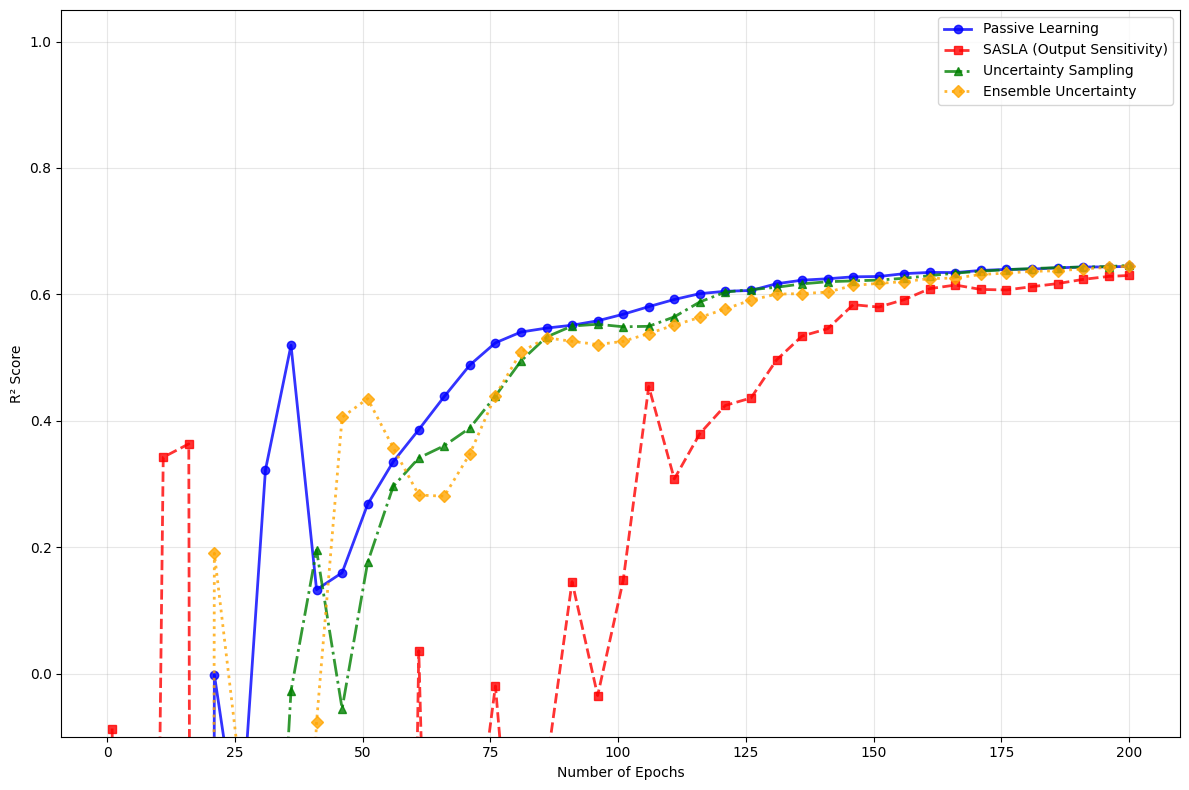


R² Score Analysis:
Passive Learning:
  Average: -0.7881
  Final: 0.6443
  Range: -23.8603 - 0.6443
  Improvement: 8.1899
SASLA (Output Sensitivity):
  Average: -1.6272
  Final: 0.6299
  Range: -18.6617 - 0.6299
  Improvement: 0.7169
Uncertainty Sampling:
  Average: -0.2950
  Final: 0.6459
  Range: -12.2400 - 0.6459
  Improvement: 12.8859
Ensemble Uncertainty:
  Average: -0.8878
  Final: 0.6445
  Range: -21.8147 - 0.6445
  Improvement: 8.9160


In [90]:
# Plot 2: R² score vs number of epochs for each approach
plt.figure(figsize=(12, 8))

colors = ['blue', 'red', 'green', 'orange']
markers = ['o', 's', '^', 'D']
linestyles = ['-', '--', '-.', ':']

for i, (method_name, data) in enumerate(models_data.items()):
    epochs = data['epoch_numbers']
    r2_scores = data['r2_scores']
    
    # Plot R² score progression
    plt.plot(epochs, r2_scores, 
             color=colors[i], 
             marker=markers[i], 
             linestyle=linestyles[i],
             linewidth=2, 
             markersize=6,
             label=method_name,
             alpha=0.8)

plt.xlabel('Number of Epochs')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-0.1, 1.05)  # R² typically ranges from 0 to 1 for good models
plt.tight_layout()
plt.savefig('../results/housing/r2_score_vs_epochs.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Print R² score analysis
print("\nR² Score Analysis:")
for method_name, data in models_data.items():
    r2_scores = data['r2_scores']
    print(f"{method_name}:")
    print(f"  Average: {np.mean(r2_scores):.4f}")
    print(f"  Final: {r2_scores[-1]:.4f}")
    print(f"  Range: {min(r2_scores):.4f} - {max(r2_scores):.4f}")
    print(f"  Improvement: {r2_scores[-1] - r2_scores[0]:.4f}")


In [91]:
models_data.items()

dict_items([('Passive Learning', {'model_type': 'passive', 'pattern_presentations': [16512, 99072, 181632, 264192, 346752, 429312, 511872, 594432, 676992, 759552, 842112, 924672, 1007232, 1089792, 1172352, 1254912, 1337472, 1420032, 1502592, 1585152, 1667712, 1750272, 1832832, 1915392, 1997952, 2080512, 2163072, 2245632, 2328192, 2410752, 2493312, 2575872, 2658432, 2740992, 2823552, 2906112, 2988672, 3071232, 3153792, 3236352, 3302400], 'generalization_factors': [0, 0, 0, 0, -0.10606388923736643, 0, 1.0706275059826622, 0.9933798372522427, 0.9591434068529001, 0.9573486058641196, 0.9647984937740687, 0.9672150153165737, 0.9676317622197447, 0.9667935657999278, 0.9661310837798425, 0.966993384689684, 0.9697805121692914, 0.9739866805857483, 0.9786989039665197, 0.9831454068735229, 0.9867527334849344, 0.9892257842666715, 0.9907542074172658, 0.9916502927638099, 0.9924840588800715, 0.9943812594571735, 0.9979702155556246, 1.002529886947567, 1.003816287231212, 1.0011563480465988, 1.0009648868914405

In [92]:
# Additional comparison analysis
print("PERFORMANCE COMPARISON SUMMARY")
print("=" * 80)
print(f"{'Method':<25} {'Final Test R²':<15} {'Final Test MSE':<15} {'Avg Gen Factor':<15} {'Final Presentations':<20}")
print("-" * 80)

for method_name, data in models_data.items():
    final_test_r2 = data['final_test_r2']
    final_test_mse = data['final_test_mse']
    avg_gen_factor = np.mean(data['generalization_factors'])
    final_presentations = data['pattern_presentations'][-1]
    
    print(f"{method_name:<25} {final_test_r2:<15.4f} {final_test_mse:<15.4f} {avg_gen_factor:<15.4f} {final_presentations:<20.0f}")

print("\nMethod Rankings:")
print("\nBest Test R² Score:")
best_r2_method = max(models_data.items(), key=lambda x: x[1]['final_test_r2'])
print(f"  {best_r2_method[0]}: {best_r2_method[1]['final_test_r2']:.4f}")

print("\nLowest Test MSE:")
best_mse_method = min(models_data.items(), key=lambda x: x[1]['final_test_mse'])
print(f"  {best_mse_method[0]}: {best_mse_method[1]['final_test_mse']:.4f}")

print("\nBest Generalization Factor:")
best_gen_method = max(models_data.items(), key=lambda x: np.mean(x[1]['generalization_factors']))
print(f"  {best_gen_method[0]}: {np.mean(best_gen_method[1]['generalization_factors']):.4f}")

print("\nMost Efficient (Fewest Final Presentations):")
most_efficient_method = min(models_data.items(), key=lambda x: x[1]['pattern_presentations'][-1])
print(f"  {most_efficient_method[0]}: {most_efficient_method[1]['pattern_presentations'][-1]:.0f} presentations")

# Learning curve analysis
print("\nLearning Progress Analysis:")
for method_name, data in models_data.items():
    r2_improvement = data['r2_scores'][-1] - data['r2_scores'][0]
    r2_final = data['r2_scores'][-1]
    print(f"{method_name}:")
    print(f"  R² improvement during training: {r2_improvement:+.4f}")
    print(f"  Final R² score: {r2_final:.4f}")
    print(f"  Generalization stability: {np.std(data['generalization_factors']):.4f} (lower is better)")


PERFORMANCE COMPARISON SUMMARY
Method                    Final Test R²   Final Test MSE  Avg Gen Factor  Final Presentations 
--------------------------------------------------------------------------------
Passive Learning          0.6443          0.0829          0.8434          3302400             
SASLA (Output Sensitivity) 0.6299          0.0863          0.6157          445400              
Uncertainty Sampling      0.6459          0.0826          0.7550          665600              
Ensemble Uncertainty      0.6445          0.0829          0.7914          827400              

Method Rankings:

Best Test R² Score:
  Uncertainty Sampling: 0.6459

Lowest Test MSE:
  Uncertainty Sampling: 0.0826

Best Generalization Factor:
  Passive Learning: 0.8434

Most Efficient (Fewest Final Presentations):
  SASLA (Output Sensitivity): 445400 presentations

Learning Progress Analysis:
Passive Learning:
  R² improvement during training: +8.1899
  Final R² score: 0.6443
  Generalization stability